<a href="https://colab.research.google.com/github/ndrep/bioinformatics/blob/main/Bioinformatic_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Mount drive

In [ ]:
from google.colab import drive

drive.mount("/drive/")

Mounted at /drive/


#Installing requirements

In [8]:
!pip install -q "cache_decorator[all]"==2.0.8 humanize scikit-learn
!pip install -q barplots plot_keras_history epigenomic_dataset>=1.1.7
!pip install -q ucsc_genomes_downloader>=1.1.22 keras_bed_sequence>=1.1.5
!pip install -q keras_mixed_sequence ray seaborn minepy boruta prince cmake
!pip install -q multicoretsne silence_tensorflow>=1.1.1
!pip install tsnecuda==3.0.0+cu110 -f https://tsnecuda.isx.ai/tsnecuda_stable.html --no-dependencies
!pip install -q faiss tbb
!pip install extra_keras_metrics
!pip install -U keras-tuner
!pip install -q tabulate
!pip install -q multiprocess
!pip install -q IProgress

Looking in links: https://tsnecuda.isx.ai/tsnecuda_stable.html
ERROR: Could not find a version that satisfies the requirement faiss (from versions: none)
ERROR: No matching distribution found for faiss


#Import packages

In [71]:
from typing import Dict, List, Tuple, Optional
from cache_decorator import Cache
import numpy as np
import pandas as pd
from tqdm.auto import tqdm
from matplotlib.axes import Axes
from matplotlib.figure import Figure
from matplotlib.colors import ListedColormap, LogNorm
from multiprocessing import cpu_count, Pool
import matplotlib.pyplot as plt
from epigenomic_dataset.utils import get_cell_lines
from typing import Tuple
from tensorflow.keras.layers import Input, Dense, Dropout, BatchNormalization, ReLU, Concatenate, Layer
from tensorflow.keras.layers import Conv1D, MaxPool1D, GlobalAveragePooling1D, GlobalMaxPool1D, Flatten, PReLU, MaxPooling1D, GlobalMaxPooling1D
from tensorflow.keras import regularizers
from tensorflow.keras.models import Model
from extra_keras_metrics import get_complete_binary_metrics
from tsnecuda import TSNE
from keras_mixed_sequence import MixedSequence, VectorSequence
from keras_bed_sequence import BedSequence
from keras_tuner import BayesianOptimization, Hyperband
import keras_tuner as kt
import tensorflow.keras
import tensorflow as tf
import keras
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.python.keras.layers.pooling import AveragePooling1D
import warnings
warnings.filterwarnings('ignore')
import seaborn as sbn
from epigenomic_dataset import active_promoters_vs_inactive_promoters, active_enhancers_vs_inactive_enhancers
from sklearn.impute import KNNImputer
from sklearn.preprocessing import RobustScaler
from scipy.stats import pearsonr, spearmanr
from minepy import MINE
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from boruta import BorutaPy
from multiprocessing import cpu_count
from ucsc_genomes_downloader import Genome
from sklearn.decomposition import PCA
import gc
from sklearn.model_selection import StratifiedShuffleSplit, ShuffleSplit
from epigenomic_dataset.utils import normalize_epigenomic_data
from barplots import barplots
from scipy.stats import wilcoxon
from sklearn.linear_model import SGDClassifier
from sklearn.feature_selection import RFE
from multiprocess import cpu_count

# Import Epigenomic Data

The cell line has going to be uncommitted for the evaluation

In [72]:
cell_line='MCF-7'
#cell_line='K562'
#cell_line='A549'

Importing epigenomic data with binarize label

In [73]:
X_AP_vs_IP, y_AP_vs_IP= active_promoters_vs_inactive_promoters(cell_line=cell_line, binarize=True)
X_AE_vs_IE, y_AE_vs_IE=active_enhancers_vs_inactive_enhancers(cell_line=cell_line, binarize=True, min_active_tpm_value=0, max_inactive_tpm_value=0)

samples = {
    'promoter':X_AP_vs_IP,
    'enhancer':X_AE_vs_IE
}

labels = {
    'promoter':y_AP_vs_IP, 
    'enhancer':y_AE_vs_IE
}

Epigenoimic data example

In [74]:
samples['promoter']

chrom                              SNIP1  CREB1  NRF1  TAF1   ZFX  H2AFZ  \
chrom chromStart chromEnd  strand                                          
chr1  628964     629220    +        0.43   0.27  0.14  0.39  0.30   0.41   
      629013     629269    +        0.55   0.21  0.23  0.39  0.32   0.38   
      629642     629898    +        0.06   0.18  0.22  0.13  0.17   0.11   
      629847     630103    +        0.25   0.87  0.78  0.87  0.11   0.36   
      629905     630161    +        0.26   1.07  0.87  0.89  0.09   0.38   
...                                  ...    ...   ...   ...   ...    ...   
chrX  154441877  154442133 +        1.27   0.71  1.16  0.47  1.03   0.57   
      154584927  154585183 +        0.00   0.00  0.00  0.00  0.00   0.00   
chrY  1452882    1453138   -        0.00   0.00  0.00  0.00  0.00   0.00   
      2500959    2501215   -        0.00   0.00  0.00  0.00  0.00   0.00   
      14055973   14056229  +        0.00   0.00  0.00  0.00  0.00   0.00   

chrom                              NFRKB  ZBTB11  ZNF331  ZNF444  ...  ZNF687  \
chrom chromStart chromEnd  strand                                 ...           
chr1  628964     629220    +        0.24    0.00    0.68    0.43  ...    0.25   
      629013     629269    +        0.21    0.00    0.72    0.43  ...    0.22   
      629642     629898    +        0.00    0.11    0.00    0.08  ...    0.05   
      629847     630103    +        0.29    0.43    0.12    0.68  ...    0.15   
      629905     630161    +        0.43    0.30    0.21    0.80  ...    0.31   
...                                  ...     ...     ...     ...  ...     ...   
chrX  154441877  154442133 +        0.73    0.38    1.37    1.18  ...    0.84   
      154584927  154585183 +        0.00    0.00    0.00    0.00  ...    0.00   
chrY  1452882    1453138   -        0.00    0.00    0.00    0.00  ...    0.00   
      2500959    2501215   -        0.00    0.00    0.00    0.00  ...    0.00   
      14055973   14056229  +        0.00    0.00    0.00    0.00  ...    0.00   

chrom                               MYC  HES1  TARDBP  RFX5  SMARCA5  KLF4  \
chrom chromStart chromEnd  strand                                            
chr1  628964     629220    +       0.00  0.41    0.18  0.35     0.33  0.48   
      629013     629269    +       0.00  0.36    0.22  0.41     0.38  0.42   
      629642     629898    +       0.00  0.14    0.11  0.20     0.09  0.16   
      629847     630103    +       0.00  0.70    0.69  0.44     0.46  0.33   
      629905     630161    +       0.00  0.85    0.92  0.54     0.60  0.26   
...                                 ...   ...     ...   ...      ...   ...   
chrX  154441877  154442133 +       1.11  0.49    0.86  1.59     0.83  0.41   
      154584927  154585183 +       0.00  0.00    0.00  0.00     0.00  0.00   
chrY  1452882    1453138   -       0.00  0.00    0.00  0.00     0.00  0.00   
      2500959    2501215   -       0.00  0.00    0.00  0.00     0.00  0.00   
      14055973   14056229  +       0.00  0.00    0.00  0.00     0.00  0.00   

chrom                              SIN3A  E2F4  E4F1  
chrom chromStart chromEnd  strand                     
chr1  628964     629220    +        0.28  0.00  0.17  
      629013     629269    +        0.40  0.00  0.22  
      629642     629898    +        0.26  0.31  0.00  
      629847     630103    +        0.57  0.59  0.41  
      629905     630161    +        0.69  0.45  0.67  
...                                  ...   ...   ...  
chrX  154441877  154442133 +        0.77  0.47  0.70  
      154584927  154585183 +        0.00  0.00  0.00  
chrY  1452882    1453138   -        0.00  0.00  0.00  
      2500959    2501215   -        0.00  0.00  0.00  
      14055973   14056229  +        0.00  0.00  0.00  

[99881 rows x 117 columns]

Promoter labels example

In [76]:
labels['promoter']

MCF7
chrom chromStart chromEnd  strand       
chr1  628964     629220    +       False
      629013     629269    +       False
      629642     629898    +       False
      629847     630103    +       False
      629905     630161    +       False
...                                  ...
chrX  154441877  154442133 +       False
      154584927  154585183 +       False
chrY  1452882    1453138   -       False
      2500959    2501215   -       False
      14055973   14056229  +       False

[99881 rows x 1 columns]

# Data Cleaning

Ratio evaluation between samples and features.

In [77]:
samples['promoter'].shape[0] / samples['promoter'].shape[1]

853.6837606837607

In [78]:
samples['enhancer'].shape[0] / samples['enhancer'].shape[1]

540.8974358974359

### Nan Imputation

If are present some Nan values they are going to be modified through KNNImputer

Promoter

In [79]:
samples['promoter'].isna().sum().sum()

182

In [80]:
labels['promoter'].isna().sum().sum()

0

Enhancer

In [81]:
samples['enhancer'].isna().sum().sum()

0

In [82]:
labels['enhancer'].isna().sum().sum()

0

In [83]:
def knn_imputation(df:pd.DataFrame, neighbours:int=5, weights:str='uniform')->pd.DataFrame:
    """Return provided dataframe with NaN imputed using knn.
    
    Parameters
    --------------------
    df:pd.DataFrame,
        The dataframe to impute.
    neighbours:int=5,
        The number of neighbours to consider.
    weights:str='uniform',
        Weight function used in prediction.
        
    Returns
    --------------------
    The dataframe with the NaN values imputed.
    """
    return pd.DataFrame(
        KNNImputer(n_neighbors=neighbours, weights=weights).fit_transform(df.values),
        columns=df.columns,
        index=df.index
    )

Nan value imputation for Promoter and Enhancer sample

In [84]:
for region in samples.items():
  samples[region[0]] = knn_imputation(samples[region[0]])

Check if all Nan values were be imputed

In [85]:
for region in samples.items():
  print('Nan values in {} is {}'.format(region[0], samples[region[0]].isna().sum().sum()))

Nan values in promoter is 0
Nan values in enhancer is 0


### Drop Constant features

All constant feature are not useful so they will be dropped

In [86]:
def drop_constant_features(df:pd.DataFrame)->pd.DataFrame:
    """Return DataFrame without constant features."""
    return df.loc[:, (df != df.iloc[0]).any()]

In [87]:
dropped_promoter = drop_constant_features(samples['promoter'])
dropped_enhancer = drop_constant_features(samples['enhancer'])

Check if some constant features has been drop

In [88]:
dropped_promoter.shape != samples['promoter'].shape

False

In [89]:
dropped_enhancer.shape != samples['enhancer'].shape

False

In [90]:
samples['promoter'] = dropped_promoter
samples['enhancer'] = dropped_enhancer

### Data Scaling

In [91]:
def robust_zscoring(df:pd.DataFrame)->pd.DataFrame:
    """Return given dataframe scaled using robust z-scoring."""
    return pd.DataFrame(
        RobustScaler().fit_transform(df.values),
        columns=df.columns,
        index=df.index
    )

In [92]:
samples['promoter'] = robust_zscoring(samples['promoter'])
samples['enhancer'] = robust_zscoring(samples['enhancer'])

### Class Balance

Check if balance is between 1/10 and 1/100

Active-Inactive promoter ratio: 0.3010929175296677
Active fraction in promoter: 0.23141538430732572
Active-Inactive enhancer ratio: 0.08412992085517525
Active fraction in enhancer: 0.07760132732875089


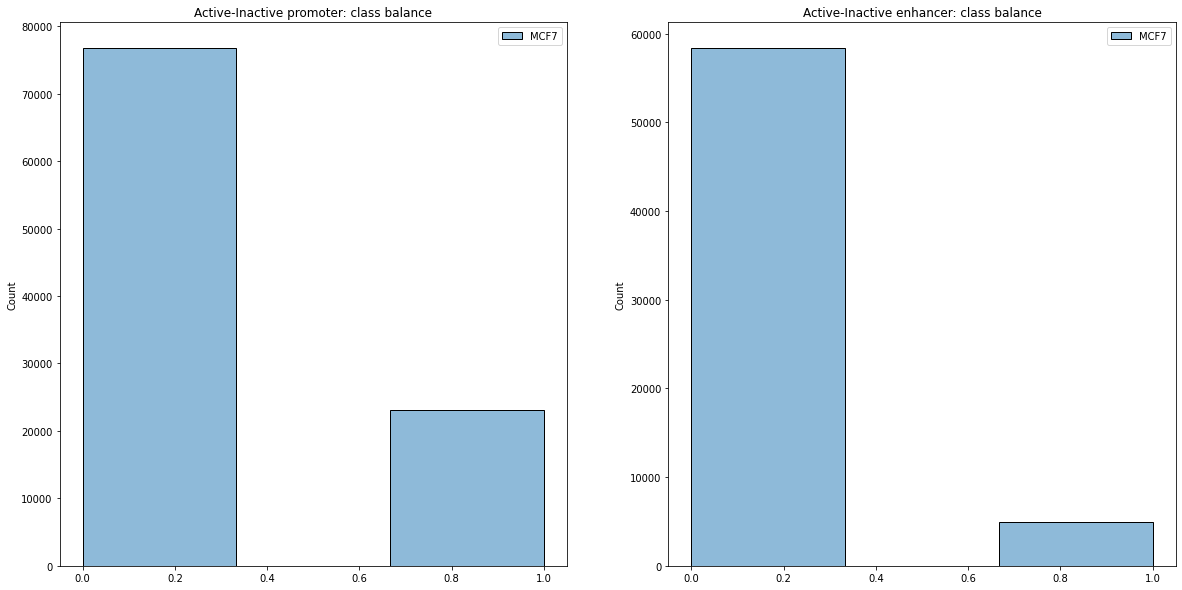

In [93]:
if cell_line == 'MCF-7':
    cell_line = 'MCF7'

_, axs = plt.subplots(ncols=2, figsize=(20, 10))
for i, (region, y) in enumerate(labels.items()):
    axes = sbn.histplot(
        data=y,
        bins=3,
        ax=axs[i],
    )

    axes.set_title(f"Active-Inactive {region}: class balance")
    counts = y[cell_line].value_counts()
    print(f"Active-Inactive {region} ratio: {counts[1]/counts[0]}")
    print(f"Active fraction in {region}: {counts[1]/(counts[0]+counts[1])}")

For all cell line in this project are not necessary perform a class balance

# Features Correlation & Features Selection

## Feature correlation with Output

In [94]:
p_value_threshold = 0.05
correlation_threshold = 0.01

In [95]:
not_correlated_features = {'promoter':set(), 'enhancer':set()}

### Linear correlation with Pearson index


In [96]:
for (X,y) in zip(samples.items(), labels.items()):
  for feature in tqdm(X[1].columns, desc=f"Running Pearson test", dynamic_ncols=True, leave=False):
    correlation, p_value = pearsonr(X[1][feature].values.flatten(), y[1].values.flatten())
    if p_value > p_value_threshold:
      print(f"In {X[0]} the feature {feature} does not correlate in a statistically significant manner with the output. p-value:{p_value} -- correlation:{correlation}")
      not_correlated_features[X[0]].add(feature)

Running Pearson test:   0%|                                                                                   …

In promoter the feature CSDE1 does not correlate in a statistically significant manner with the output. p-value:0.7882660497668235 -- correlation:0.0008497867713343466


Running Pearson test:   0%|                                                                                   …

In enhancer the feature ARID3A does not correlate in a statistically significant manner with the output. p-value:0.17137943506880318 -- correlation:0.005437168115820586
In enhancer the feature CSDE1 does not correlate in a statistically significant manner with the output. p-value:0.17875231490080695 -- correlation:0.005345032112865597
In enhancer the feature LARP7 does not correlate in a statistically significant manner with the output. p-value:0.5775502141098324 -- correlation:0.0022140470542511073


### Linear correlation with Spearman index

In [97]:
for (X,y) in zip(samples.items(), labels.items()):
  for feature in tqdm(X[1].columns, desc=f"Running Pearson test", dynamic_ncols=True, leave=False):
    correlation, p_value = spearmanr(X[1][feature].values.flatten(), y[1].values.flatten())
    if p_value > p_value_threshold:
      print(f"In {X[0]} the feature {feature} does not correlate in a statistically significant manner with the output. p-value:{p_value} -- correlation:{correlation}")
      not_correlated_features[X[0]].add(feature)

Running Pearson test:   0%|                                                                                   …

Running Pearson test:   0%|                                                                                   …

In enhancer the feature ARID3A does not correlate in a statistically significant manner with the output. p-value:0.07717396887110077 -- correlation:0.007025367102546445
In enhancer the feature CSDE1 does not correlate in a statistically significant manner with the output. p-value:0.7389310503081925 -- correlation:-0.0013248089003075486
In enhancer the feature CEBPG does not correlate in a statistically significant manner with the output. p-value:0.6321541439395504 -- correlation:0.001902911411879234
In enhancer the feature LARP7 does not correlate in a statistically significant manner with the output. p-value:0.1536808173366652 -- correlation:0.005671162886044895
In enhancer the feature E2F4 does not correlate in a statistically significant manner with the output. p-value:0.8129300883367411 -- correlation:-0.0009407201214266508


In [98]:
not_correlated_features

{'promoter': {'CSDE1'},
 'enhancer': {'ARID3A', 'CEBPG', 'CSDE1', 'E2F4', 'LARP7'}}

### Not linear correlation with MIC

In [99]:
not_linear_correlation = {'promoter':set(), 'enhancer':set()}
for (X,y) in zip(samples.items(), labels.items()):
    for items in not_correlated_features.items():
        for feature in tqdm(items[1], desc=f"Running MINE test", dynamic_ncols=True, leave=False):
            mine = MINE()
            mine.compute_score(X[1][feature].ravel(), y[1].values.ravel())
            score = mine.mic()
            if score < correlation_threshold:
                print(f"In {X[0]} the feature {feature} does not correlate in a statistically significant manner with the output.")
                not_linear_correlation[items[0]].add(feature)
                
for region in not_linear_correlation.items():
    not_linear_correlation[region[0]] = list(region[1])

Running MINE test:   0%|                                                                                      …

In promoter the feature CSDE1 does not correlate in a statistically significant manner with the output.


Running MINE test:   0%|                                                                                      …

In promoter the feature CSDE1 does not correlate in a statistically significant manner with the output.
In promoter the feature LARP7 does not correlate in a statistically significant manner with the output.


Running MINE test:   0%|                                                                                      …

In enhancer the feature CSDE1 does not correlate in a statistically significant manner with the output.


Running MINE test:   0%|                                                                                      …

In enhancer the feature CSDE1 does not correlate in a statistically significant manner with the output.
In enhancer the feature E2F4 does not correlate in a statistically significant manner with the output.
In enhancer the feature ARID3A does not correlate in a statistically significant manner with the output.
In enhancer the feature LARP7 does not correlate in a statistically significant manner with the output.


### Drop features not correlated with output

Before feature drop

In [100]:
for region in samples.items():
  print(region[1].shape)

(99881, 117)
(63285, 117)


In [101]:
for region in samples.items():
  region[1].drop(list(not_linear_correlation[region[0]]), axis=1, inplace=True)

After feature drop

In [102]:
for region in samples.items():
  print(region[1].shape)

(99881, 116)
(63285, 113)


## Correlation between features

### Spearman

In [103]:
@Cache(
    cache_path="spearmanr/{_hash}.json",
    args_to_ignore=["X"]
)
def compute_spearmanr(
    X:pd.DataFrame,
    feature_left: str,
    feature_right: str,
    cell_line: str,
    region: str
) -> Dict:
    """Returns Spearman correlation.
    
    Implementative details
    ------------------------------
    We may need to recompute this value across
    multiple re-runs of the jupyter notebook,
    so since it takes a bit of time to do so we cache it.
    
    Parameters
    ----------------------
    X:pd.DataFrame,
        The epigenomic data.
    feature_left: str,
        The left features to compute pearson for.
    feature_right: str,
        The right features to compute pearson for.
    cell_line: str,
        The cell line.
    region: str,
        The cis-regulatory region of interest.
    """
    correlation, p_value = spearmanr(
        X[feature_left].values.flatten(),
        X[feature_right].values.flatten(),
    )
    return dict(
        correlation=correlation,
        p_value=p_value
    )              

### Pearson

In [104]:
@Cache(
    cache_path="pearson/{_hash}.json",
    args_to_ignore=["X"]
)
def compute_pearsonr(
    X:pd.DataFrame,
    feature_left: str,
    feature_right: str,
    cell_line: str,
    region: str
) -> Dict:
    """Returns Pearson correlation.
    
    Implementative details
    ------------------------------
    We may need to recompute this value across
    multiple re-runs of the jupyter notebook,
    so since it takes a bit of time to do so we cache it.
    
    Parameters
    ----------------------
    X:pd.DataFrame,
        The epigenomic data.
    feature_left: str,
        The left features to compute pearson for.
    feature_right: str,
        The right features to compute pearson for.
    cell_line: str,
        The cell line.
    region: str,
        The cis-regulatory region of interest.
    """
    correlation, p_value = pearsonr(
        X[feature_left].values.flatten(),
        X[feature_right].values.flatten(),
    )
    return dict(
        correlation=correlation,
        p_value=p_value
    )

### Apply pearson function between features

In [105]:
highly_correlated_future = {'promoter':[], 'enhancer':[]}
score = {'promoter':[], 'enhancer':[]}

for X in tqdm(samples.items(), desc=f"Running Spearman test", dynamic_ncols=True, leave=False):
  for feature_left in tqdm(X[1].columns, dynamic_ncols=True, leave=False):
      for feature_right in X[1].columns:
          pearson_result = compute_pearsonr(
              X[1],
              feature_left,
              feature_right,
              cell_line=cell_line,
              region="promoters"
          )

          score[X[0]].append(pearson_result)

          if feature_left!=feature_right and pearson_result["p_value"] < p_value_threshold and np.abs(pearson_result["correlation"]) > 0.95:
              correlation = pearson_result["correlation"]
              print(f"The feature {feature_left} is highly correlated with {feature_right} ({correlation}).")
              highly_correlated_future[X[0]].append(feature_left)

Running Spearman test:   0%|                                                                                  …

  0%|                                                                                                         …

  0%|                                                                                                         …

In [106]:
print(highly_correlated_future)
print(score)

### Drop highly correleted feature

for region in samples.items():
  region[1].drop(highly_correlated_future[region[0]], axis=1, inplace=True)

{'promoter': [], 'enhancer': []}
{'promoter': [{'correlation': 1.0, 'p_value': 0.0}, {'correlation': 0.05803111255761807, 'p_value': 2.990648702433328e-75}, {'correlation': 0.07073469296120213, 'p_value': 5.799739444422968e-111}, {'correlation': 0.19206652758414633, 'p_value': 0.0}, {'correlation': 0.12591650902102683, 'p_value': 0.0}, {'correlation': 0.21395168169483425, 'p_value': 0.0}, {'correlation': 0.07675055330699444, 'p_value': 2.3966557057400733e-130}, {'correlation': 0.09865290378528062, 'p_value': 1.964322967559287e-214}, {'correlation': 0.09469305891213797, 'p_value': 1.1824821567050181e-197}, {'correlation': 0.16559522135555302, 'p_value': 0.0}, {'correlation': 0.17384293880704, 'p_value': 0.0}, {'correlation': 0.21313155152264726, 'p_value': 0.0}, {'correlation': 0.06401525599915861, 'p_value': 3.4199027610832525e-91}, {'correlation': 0.1379915493312425, 'p_value': 0.0}, {'correlation': 0.2606460942502865, 'p_value': 0.0}, {'correlation': 0.14485177618758385, 'p_value': 0

### Print 3 most highly correlated feature

In [108]:
def features_correlation(X: pd.DataFrame, region: str):
    """Computes the correlation between the features of the dataset.

    Create a list of correlation according to the Pearson coefficient between
    the features of the given data.

    Args:
        X: the dataset to consider.
        region: the region of interest.

    Returns:
        A list of tuple of the form:
          (correlation score, p_value, first feature, second feature)
    """
    scores = []

    for i, feature_1 in tqdm(enumerate(X.columns),
                             total = len(X.columns),
                             desc = f"Running tests for {region}",
                             dynamic_ncols = True,
                             leave = False):
        for feature_2 in X.columns[i+1:]:
            correlation, p_value = pearsonr(X[feature_1].values.ravel(),
                                            X[feature_2].values.ravel())
            scores.append((correlation, p_value, feature_1, feature_2))

    return scores

In [109]:
feature_corr_scores = {
    region: list()
    for region in samples.keys()
}

for region, X in samples.items():
    feature_corr_scores[region] = features_correlation(X, region)
    
feature_corr_scores = {
    region: sorted(score, 
                   key=lambda x: np.abs(x[0]), 
                   reverse=True)
    for region, score in feature_corr_scores.items()
}

Running tests for promoter:   0%|                                                                             …

Running tests for enhancer:   0%|                                                                             …

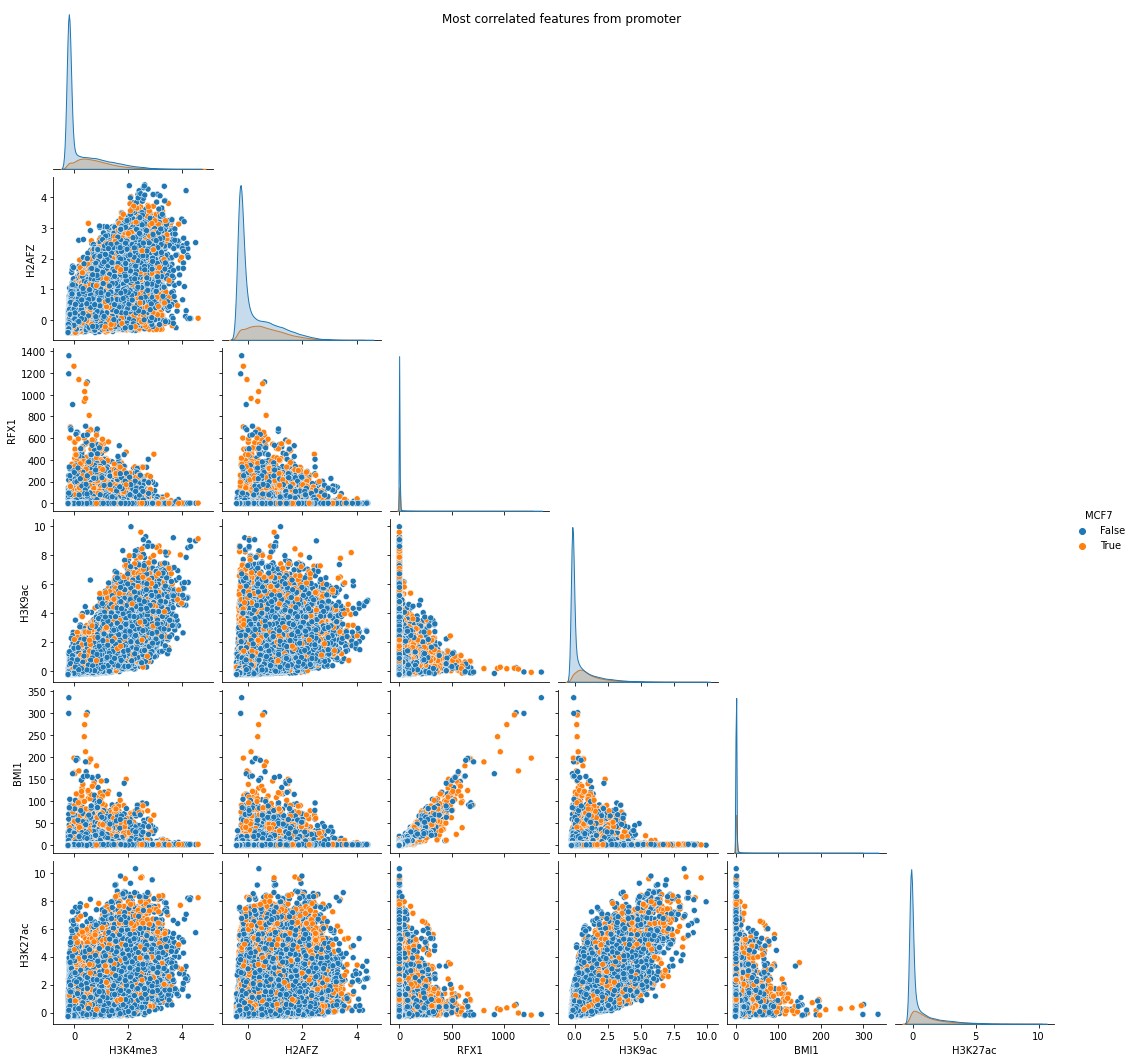

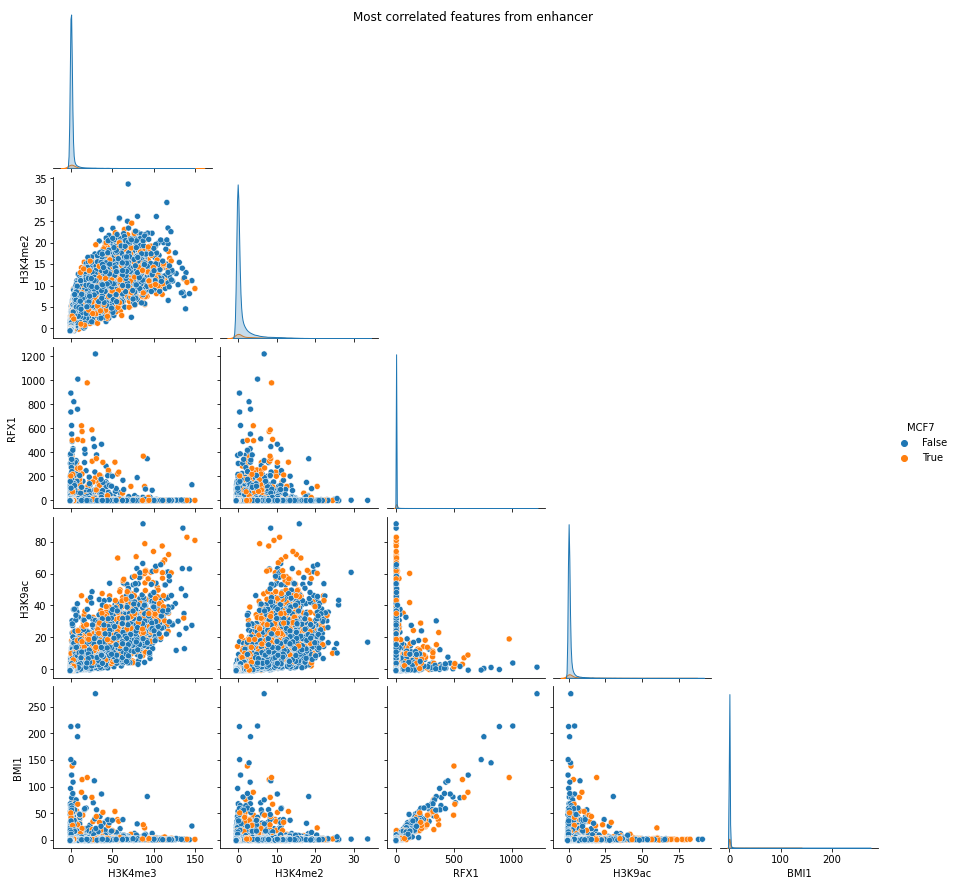

In [110]:
for region, X in samples.items():
    # creates the cartesian product between the top three correlated features
    _, _, firsts, seconds = list(zip(*feature_corr_scores[region][:3]))
    columns = list(set(firsts+seconds))
    pp = sbn.pairplot(pd.concat([X[columns], labels[region]], axis=1),
                 hue=labels[region].columns[0],
                 corner=True)
    pp.fig.suptitle(f"Most correlated features from {region}")

### Create Boruta selection function

In [111]:
def execute_boruta_feature_selection(
    X_train: pd.DataFrame,
    y_train: np.ndarray,
    holdout_number: int,
    task_name: str,
    max_iter: int = 100,
    regression: bool = False,
):
    """Returns tuple with list of kept features and list of discared features.
    
    Parameters
    --------------------------
    X_train: pd.DataFrame,
        The data reserved for the input of the training of the Boruta model.
    y_train: np.ndarray,
        The data reserved for the output of the training of the Boruta model.
    holdout_number: int,
        The current holdout number.
    regression: bool,
        Whether the task is a binary classification one (False) or a regression one (True).
    task_name: str,
        The name of the task.
    max_iter: int = 100,
        Number of iterations to run Boruta for.
    """
    if regression:
        model = RandomForestRegressor(n_jobs=cpu_count(), max_depth=5)
    else:
        model = RandomForestClassifier(n_jobs=cpu_count(), class_weight='balanced_subsample', max_depth=5)
    
    boruta_selector = BorutaPy(
        model,
        n_estimators='auto',
        verbose=False,
        alpha=0.05,
        max_iter=max_iter, 
        random_state=42,
    )
    boruta_selector.fit(X_train.values, y_train)
    
    kept_features = list(X_train.columns[boruta_selector.support_])
    discarded_features = list(X_train.columns[~boruta_selector.support_])
    
    return kept_features, discarded_features

### Recursive Feature Elimination SDG

In [112]:
def recursive_feature_elimination_with_sgd(X: pd.DataFrame,
                                           y: np.ndarray,
                                           region: str,
                                           holdout_number: int,
                                           n_features: int = 50,
                                           deletion_step: int = 10,
                                           verbose: int = 0) -> pd.DataFrame:
    """Performes an RFE procedure with SGD as internal predictor.
    
    The feauters are ranked according to the selection criterium of the SGD
    predictor, with log loss and L1 penalty, and removed by a step of 10
    features at a time. This procedure goes on until the required number of
    features is reached.
    
    Args:
        X: the dataset to consider.
        y: the corresponding labels.
        region: the region of interest.
        holdout_number: the holdout number.
        n_features: number of features to select.
        deletion_step: number of features to remove at each step.
        verbose: verbosity of the method.

    Returns:
        A new dataframe with the selected features.
    """
    clf = SGDClassifier(loss="log",
                        penalty="l1",
                        verbose=verbose,
                        n_jobs=cpu_count(),
                        early_stopping=True,
                        class_weight="balanced")
    rfe = RFE(clf,
              n_features_to_select=n_features,
              step=deletion_step,
              verbose=verbose)
    rfe = rfe.fit(X, y)
    X_new = pd.DataFrame(rfe.transform(X),
                         columns=X.columns[rfe.get_support()],
                         index=X.index)
    return X_new

# Import Sequence Data

Try to copy genomes folder from Drive to avoid download of data

In [113]:
#%cp -r /genomes /content/

genome = Genome("hg38")

Loading chromosomes for genome hg38:   0%|                                                                    …

In [114]:
def to_bed(data:pd.DataFrame)->pd.DataFrame:
    """Return bed coordinates from given dataset."""
    return data.reset_index()[data.index.names]

Bind sequence data to promoter and enhancer labels

In [115]:
sequence = {'promoter':pd.DataFrame(
                        np.array(BedSequence(
                            genome,
                            bed=to_bed(labels['promoter']),
                            batch_size=1
                        )).reshape(-1, 4*256),
                        index=labels['promoter'].index
                    )
            , 
            'enhancer': pd.DataFrame(
                        np.array(BedSequence(
                            genome,
                            bed=to_bed(labels['enhancer']),
                            batch_size=1
                        )).reshape(-1, 4*256),
                        index=labels['enhancer'].index
                    )
          }

In [116]:
sequence

{'promoter':                                    0     1     2     3     4     5     6     \
 chrom chromStart chromEnd  strand                                             
 chr1  628964     629220    +        0.0   0.0   0.0   1.0   0.0   0.0   1.0   
       629013     629269    +        1.0   0.0   0.0   0.0   0.0   1.0   0.0   
       629642     629898    +        0.0   0.0   1.0   0.0   0.0   0.0   0.0   
       629847     630103    +        0.0   0.0   1.0   0.0   0.0   0.0   0.0   
       629905     630161    +        0.0   1.0   0.0   0.0   1.0   0.0   0.0   
 ...                                 ...   ...   ...   ...   ...   ...   ...   
 chrX  154441877  154442133 +        0.0   0.0   1.0   0.0   0.0   0.0   0.0   
       154584927  154585183 +        0.0   1.0   0.0   0.0   1.0   0.0   0.0   
 chrY  1452882    1453138   -        0.0   0.0   0.0   1.0   0.0   1.0   0.0   
       2500959    2501215   -        0.0   1.0   0.0   0.0   0.0   0.0   1.0   
       14055973   14056229  

# Data visualization with t-SNE and PCA 

In [117]:
tasks = {
    "x":[
        *[
            val.values
            for val in samples.values()
        ]
    ],
    "y":[
        *[
            val.values.ravel()
            for val in labels.values()
        ]
    ],
    "titles":[
        "Epigenomes promoters",
        "Epigenomes enhancers"
    ]
}

tasks


xs = tasks["x"]
ys = tasks["y"]
titles = tasks["titles"]

assert len(xs) == len(ys) == len(titles)

for x, y in zip(xs, ys):
    assert x.shape[0] == y.shape[0]

In [118]:
tasks_seq = {
    "x":[
        *[
            val.values
            for val in sequence.values()
        ]
    ],
    "y":[
        *[
            val.values.ravel()
            for val in labels.values()
        ]
    ],
    "titles":[
        "Sequence promoters",
        "Sequence enhancers"
    ]
}

tasks_seq


xss = tasks_seq["x"]
yss = tasks_seq["y"]
titless = tasks_seq["titles"]

assert len(xss) == len(yss) == len(titless)

for x, y in zip(xss, yss):
    assert x.shape[0] == y.shape[0]

### PCA decomposition

In [119]:
def pca(x:np.ndarray)->np.ndarray:
    return PCA(n_components=2, random_state=42).fit_transform(x)

#### Epigenomes data visualization 

Computing PCAs:   0%|          | 0/2 [00:00<?, ?it/s]

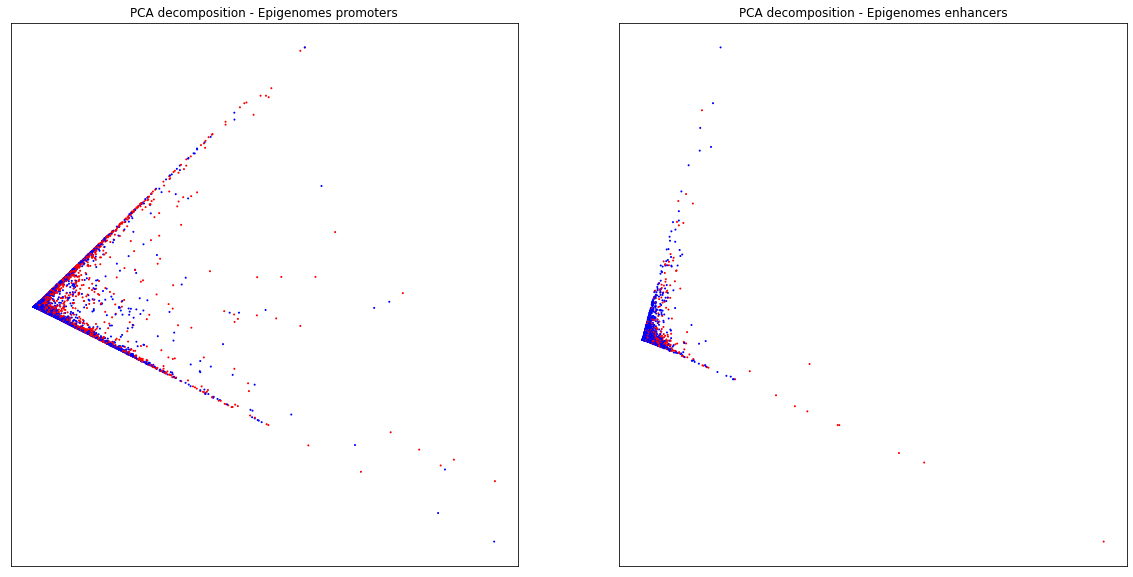

In [120]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 10))

for x, y, title, axis in tqdm(zip(xs, ys, titles, axes.flatten()), desc="Computing PCAs", total=len(xs)):
    axis.scatter(*pca(x).T, s=1, c=['#ff0000' if i else '#0000ff' for i in y])
    axis.xaxis.set_visible(False)
    axis.yaxis.set_visible(False)
    axis.set_title(f"PCA decomposition - {title}")
plt.show()

#### Sequence data visualization

Computing PCAs:   0%|          | 0/2 [00:00<?, ?it/s]

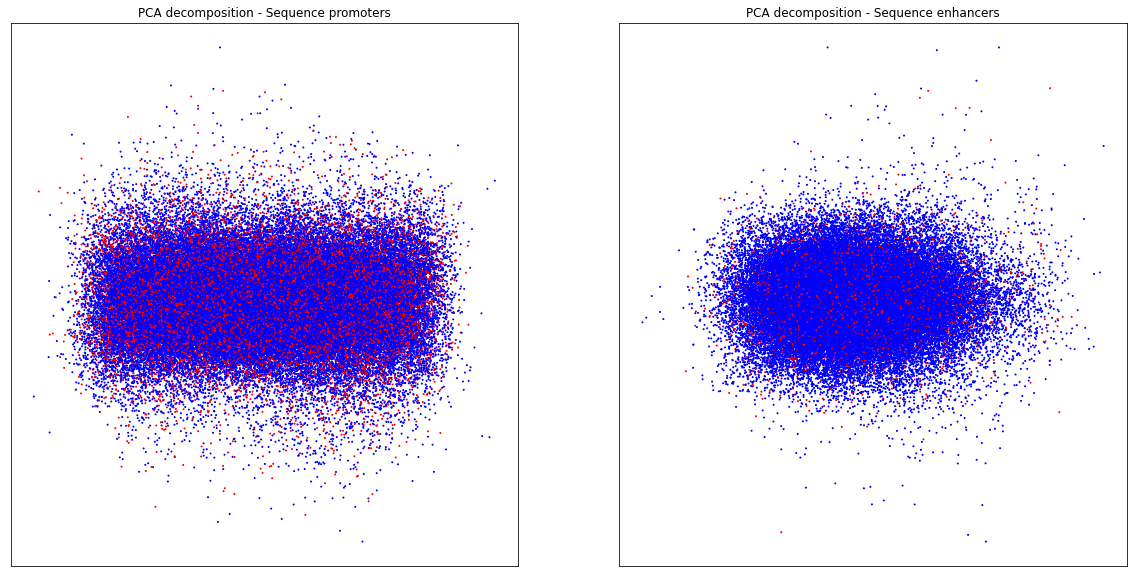

In [121]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 10))

for x, y, title, axis in tqdm(zip(xss, yss, titless, axes.flatten()), desc="Computing PCAs", total=len(xss)):
    axis.scatter(*pca(x).T, s=1, c=['#ff0000' if i else '#0000ff' for i in y])
    axis.xaxis.set_visible(False)
    axis.yaxis.set_visible(False)
    axis.set_title(f"PCA decomposition - {title}")
plt.show()

### t-SNE decomposition

In [122]:
def tsne(X:np.ndarray)->np.ndarray:
    return TSNE(
            perplexity= 30,
            n_iter = 1000,
            verbose=True,
        ).fit_transform(X)

#### Epigenomes data visualization

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 10))

for x, y, title, axis in tqdm(zip(xs, ys, titles, axes.flatten()), desc="Computing t-SNE", total=len(xs)):
    axis.scatter(*tsne(x).T, s=1, c=['#ff0000' if i else '#0000ff' for i in y])
    axis.xaxis.set_visible(False)
    axis.yaxis.set_visible(False)
    axis.set_title(f"t-SNE decomposition - {title}")
plt.show()

#### Sequence data visualization

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 10))

for x, y, title, axis in tqdm(zip(xss, yss, titless, axes.flatten()), desc="Computing t-SNE", total=len(xss)):
    axis.scatter(*tsne(x).T, s=1, c=['#ff0000' if i else '#0000ff' for i in y])
    axis.xaxis.set_visible(False)
    axis.yaxis.set_visible(False)
    axis.set_title(f"t-SNE decomposition - {title}")
plt.show()

# Classification Models

### FFNN model

#### Hypermodel

In [123]:
class FFNNHyperModel(kt.HyperModel):
  
  def __init__(self, input_shape):
    self.input_shape = input_shape    

  def build(self, hp):
    
    hp1 = hp.Choice('hp1', [256, 128, 64])
    hp2 = hp.Choice('hp2', [128, 64, 32])
    hp3 = hp.Choice('hp3', [32, 16, 8])

    input_epigenomic_data = Input(shape=(self.input_shape,), name="epigenomic_data")
    hidden = Dense(hp1, activation="relu", name="dense_ffnn")(input_epigenomic_data)
    hidden = PReLU(name="prelu_ffnn")(hidden)
    hidden = BatchNormalization(name="norm_ffnn")(hidden)
    hidden = Dropout(rate=0.3, name="dropout_ffnn")(hidden)

    hidden = Dense(hp2, activation="relu", name="dense_1_ffnn")(hidden)
    hidden = PReLU(name="prelu_2_ffnn")(hidden)
    hidden = BatchNormalization(name="norm_2_ffnn")(hidden)
    hidden = Dropout(rate=0.3, name="droupout_1_ffnn")(hidden)

    hidden = Dense(hp3, activation="relu", name="dense_2_ffnn")(hidden)
    hidden = PReLU(name="prelu_3_ffnn")(hidden)
    hidden = BatchNormalization(name="norm_3_ffnn")(hidden)
    hidden = Dropout(rate=0.3, name="last_hidden_ffnn")(hidden)
    
    last_hidden_ffnn = hidden
    output_ffnn = Dense(1, activation="sigmoid", name="output_ffnn")(last_hidden_ffnn)

    ffnn = Model(
        inputs=input_epigenomic_data,
        outputs=output_ffnn,
        name="Bayesian_Optimization_FFNN"
    )

    ffnn.compile(
        optimizer="nadam",
        loss="binary_crossentropy",
        metrics=get_complete_binary_metrics()
    )
    
    return ffnn


#### Baesyan Optimization Classification function

In [124]:
def baesyan_optimization_FFNN_classification(
    train_sequence: MixedSequence,
    test_sequence: MixedSequence,
    input_shape: int
)->Tuple[Model, Layer, Layer]:
    
    tuner = BayesianOptimization(
      FFNNHyperModel(input_shape),
      objective='val_accuracy',
      max_trials=2,
      overwrite=True,
      project_name="FFNN_BO"
    )

    tuner.search(
      train_sequence,
      validation_data=test_sequence,
      epochs=10,
      verbose=False,
      callbacks=[
          EarlyStopping(
              "loss",
              min_delta=0.001,
              patience=2,
              mode="min"
          )
      ]
    )
    
    model = tuner.get_best_models()[0]
        
    return model, model.get_layer("epigenomic_data").output, model.get_layer("last_hidden_ffnn").output

#### Fixed Classification Model

In [125]:
def build_fixed_model_FFNN_classification(input_shape: int):

  input_epigenomic_data = Input(shape=(input_shape,), name="epigenomic_data")
  hidden = Dense(256, activation="relu")(input_epigenomic_data)
  hidden = Dense(128, activation="relu")(hidden)
  idden = PReLU()(hidden)
  hidden = BatchNormalization()(hidden)
  hidden = Dropout(rate=0.5)(hidden)

  hidden = Dense(64, activation="relu")(hidden)
  hidden = Dropout(rate=0.5)(hidden)
  
  hidden = Dense(32, activation="relu")(hidden)
  hidden = Dense(16, activation="relu")(hidden)
  hidden = PReLU()(hidden)
  hidden = BatchNormalization()(hidden)
  hidden = Dropout(rate=0.5)(hidden)

  last_hidden_ffnn = hidden
  output_ffnn = Dense(1, activation="sigmoid")(last_hidden_ffnn)

  ffnn = Model(
      inputs=input_epigenomic_data,
      outputs=output_ffnn,
      name="Fixed_FFNN"
  )
  
  ffnn.compile(
      optimizer="nadam",
      loss="binary_crossentropy",
      metrics=get_complete_binary_metrics()
  )

  return ffnn, input_epigenomic_data, last_hidden_ffnn


#### Get sequence

In [126]:
def get_ffnn_sequence(
    X: np.ndarray,
    y: np.ndarray,
    batch_size: int = 1024
) -> MixedSequence:
    """Returns sequence to train a FFNN model on epigenomic data.
    
    Implementative details
    -------------------------
    This sequence can be used for either binary classification or
    for regresssion, just change the y accordingly.
    
    Parameters
    -------------------------
    X: np.ndarray,
        The vector from where to extract the epigenomic data.
    y: np.ndarray,
        The values the model should predict.
    batch_size: int = 1024,
        The size of the batches to generate
    
    Returns
    --------------------------
    MixedSequence object to train a FFNN.
    """
    return MixedSequence(
        x={
            "epigenomic_data": VectorSequence(
                X,
                batch_size
            )
        },
        y=VectorSequence(
            y,
            batch_size=batch_size
        )
    )

### CNN model

#### Hypermodel

In [127]:
class CNNHyperModel(kt.HyperModel):
  
  def __init__(self, window_size):
    self.window_size = window_size    

  def build(self, hp):

    input_sequence_data = Input(shape=(self.window_size, 4), name="sequence_data")
    hidden = Conv1D(64, kernel_size=5, activation="relu")(input_sequence_data)
    hidden = BatchNormalization()(hidden)
    hidden = Conv1D(64, kernel_size=5, activation="relu")(hidden)
    hidden = BatchNormalization()(hidden)
    hidden = Conv1D(64, kernel_size=5, activation="relu")(hidden)
    hidden = BatchNormalization()(hidden)
    hidden = MaxPool1D()(hidden)
    hidden = Conv1D(hp.Choice('units', [32, 64, 128]), kernel_size=hp.Choice('kernel_size', [5, 10]), activation="relu")(hidden)
    hidden = BatchNormalization()(hidden)
    hidden = Flatten()(hidden)
    hidden = Dense(hp.Choice('units1', [10, 32, 64]), activation="relu")(hidden)
    hidden = Dropout(0.3)(hidden)
    hidden = Dense(hp.Choice('units2', [10, 32, 64]), activation="relu")(hidden)
    hidden = Dropout(0.3, name="last_hidden")(hidden)
    
    last_hidden_cnn = hidden
    output_cnn = Dense(1, activation="sigmoid")(last_hidden_cnn)

    cnn = Model(
        inputs=input_sequence_data,
        outputs=output_cnn,
        name="Bayesian_Optimization_CNN"
    )

    cnn.compile(
        optimizer=tf.keras.optimizers.Nadam(learning_rate=2e-3),
        loss="binary_crossentropy",
        metrics=get_complete_binary_metrics()
    )

    return cnn


#### Baesyan Optimization Classification function

In [128]:
def baesyan_optimization_CNN_classification(
    train_sequence: MixedSequence,
    test_sequence: MixedSequence,
    input_shape: int
)->Tuple[Model, Layer, Layer]:
    
    tuner = BayesianOptimization(
      CNNHyperModel(input_shape),
      objective='val_accuracy',
      max_trials=2,
      overwrite=True,
      project_name="BO_CNN"
    )

    tuner.search(
      train_sequence,
        validation_data=test_sequence,
        epochs=10,
        verbose=False,
        callbacks=[
            EarlyStopping(
                "loss",
                min_delta=0.001,
                patience=2,
                mode="min"
            ),
        ]
    )
    
    model = tuner.get_best_models()[0]
        
    return model, model.get_layer("sequence_data").output, model.get_layer("last_hidden").output 

#### Fixed Classification Model

In [129]:
def build_fixed_model_CNN_classification(input_shape: int):
  
    input_sequence_data = Input(shape=(input_shape, 4), name="sequence_data")
    hidden = Conv1D(16, kernel_size=3, activation="relu")(input_sequence_data)
    hidden = MaxPooling1D()(hidden)

    hidden = Conv1D(32, kernel_size=3, activation="relu")(hidden)
    hidden = MaxPooling1D()(hidden)

    hidden = Conv1D(64, kernel_size=3, activation="relu")(hidden)
    hidden = MaxPooling1D()(hidden)
    hidden = Dropout(0.5)(hidden)

    hidden = GlobalMaxPooling1D()(hidden)

    hidden = Dense(128, activation="relu")(hidden)
    hidden = Dropout(0.5)(hidden)

    last_hidden_cnn = hidden
    output_cnn = Dense(1, activation="sigmoid")(last_hidden_cnn)

    cnn = Model(
        inputs=input_sequence_data,
        outputs=output_cnn,
        name="Fixed_CNN"
    )

    cnn.compile(
        optimizer=tf.keras.optimizers.Nadam(learning_rate=2e-3),
        loss="binary_crossentropy",
        metrics=get_complete_binary_metrics()
    )

    return cnn, input_sequence_data, last_hidden_cnn

#### Get sequence

In [130]:
def get_cnn_sequence(
    genome: Genome,
    bed: pd.DataFrame,
    y: np.ndarray,
    batch_size: int = 576
) -> MixedSequence:
    """Returns sequence to train a CNN model on genomic sequences.
    
    Implementative details
    -------------------------
    This sequence can be used for either binary classification or
    for regresssion, just change the y accordingly.
    
    Parameters
    -------------------------
    genome: Genome,
        The genome from where to extract the genomic sequence.
    bed: pd.DataFrame,
        The BED file coordinates describing where to extract the sequences.
    y: np.ndarray,
        The values the model should predict.
    batch_size: int = 1024,
        The size of the batches to generate
    
    Returns
    --------------------------
    MixedSequence object to train a CNN.
    """
    return MixedSequence(
        x={
            "sequence_data": BedSequence(
                genome,
                bed,
                batch_size=batch_size,
            )
        },
        y=VectorSequence(
            y,
            batch_size=batch_size
        )
    )

### MMNN Model

#### Fixed Calssification Model

In [131]:
def fixed_MMNN_classification(
  input_shape: Optional[int] = None,
  window_size: Optional[int] = None,
  input_epigenomic_data: Optional[Layer] = None,
  input_sequence_data: Optional[Layer] = None,
  last_hidden_ffnn: Optional[Layer] = None,
  last_hidden_cnn: Optional[Layer] = None
):
    """Returns Multi-Modal Neural Network model for binary classification.
    
    Implementative details
    -----------------------
    If the input shape / window size is not provided and the input layers and 
    the feature selection layers are provided, then the network will start
    to train from those layers (which are expected to be pre-trained).
    Conversely, it will create the submodules for the epigenomic and sequence
    data ex-novo.
    
    Parameters
    -----------------------
    input_shape: Optional[int] = None,
        Number of features in the input layer.
        Either the input shape or the input and output layers of the FFNN
        must be provided.
    window_size: int,
        Size of the input genomic window.
        Either the window size or the input and output layers of the CNN
        must be provided.
    input_epigenomic_data: Optional[Layer] = None,
        Input for the epigenomic data from a FFNN model.
        Either the input shape or the input and output layers of the FFNN
        must be provided.
    input_sequence_data: Optional[Layer] = None,
        Input for the sequence data from a CNN model.
        Either the window size or the input and output layers of the CNN
        must be provided.
    last_hidden_ffnn: Optional[Layer] = None,
        Feature selection layer from a FFNN model.    
        Either the input shape or the input and output layers of the FFNN
        must be provided.
    last_hidden_cnn: Optional[Layer] = None,
        Feature selection layer from a CNN model.
        Either the window size or the input and output layers of the CNN
        must be provided.
        
    Raises
    -----------------------
    ValueError,
        If the input shape is not provided and the input layer and feature selection
        layer of the FFNN are not provided.
    ValueError,
        If the window size is not provided and the input layer and feature selection
        layer of the CNN are not provided.
        
    Returns
    -----------------------
    Triple with model, input layer and output layer.
    """
    if input_shape is None and (last_hidden_ffnn is None or input_epigenomic_data is None):
        raise ValueError(
            "Either the input shape or the features selection layer and the input epigenomic "
            "layer must be provided."
        )
    if window_size is None and (last_hidden_cnn is None or input_sequence_data is None):
        raise ValueError(
            "Either the input shape or the features selection layer and the input sequence "
            "layer must be provided."
        )

    if input_shape is not None:
        _, input_epigenomic_data, last_hidden_ffnn = build_fixed_model_FFNN_classification(input_shape=input_shape)
        
    if window_size is not None:
        _, input_sequence_data, last_hidden_cnn = build_fixed_model_CNN_classification(input_shape=window_size)
    
    concatenation_layer = Concatenate()([last_hidden_ffnn,last_hidden_cnn])

    hidden = Dense(64, activation="relu")(concatenation_layer)
    hidden = Dense(64)(hidden)
    hidden = PReLU()(hidden)
    hidden = BatchNormalization()(hidden)
    hidden = Dropout(rate=0.2)(hidden)
    hidden = Dense(32)(hidden)
    hidden = PReLU()(hidden)
    hidden = BatchNormalization()(hidden)
    last_hidden_mmnn = Dropout(rate=0.2)(hidden)

    output_mmnn = Dense(1, activation="sigmoid")(last_hidden_mmnn)

    mmnn = Model(
        inputs=[input_epigenomic_data, input_sequence_data],
        outputs=output_mmnn,
        name="Fixed_MMNN" if input_shape is None else "Bayesian_Optimization_MMNN"
    )

    mmnn.compile(
        optimizer="nadam",
        loss="binary_crossentropy",
        metrics=get_complete_binary_metrics()
    )

    return mmnn

#### Get sequence

In [132]:
def get_mmnn_sequence(
    genome: Genome,
    bed: pd.DataFrame,
    X: np.ndarray,
    y: np.ndarray,
    batch_size: int = 1024
) -> MixedSequence:
    """Returns sequence to train a MMNN model on both genomic sequences and epigenomic data.
    
    Implementative details
    -------------------------
    This sequence can be used for either binary classification or
    for regresssion, just change the y accordingly.
    
    Parameters
    -------------------------
    genome: Genome,
        The genome from where to extract the genomic sequence.
    bed: pd.DataFrame,
        The BED file coordinates describing where to extract the sequences.
    X: np.ndarray,
        The vector from where to extract the epigenomic data.
    y: np.ndarray,
        The values the model should predict.
    batch_size: int = 1024,
        The size of the batches to generate
    
    Returns
    --------------------------
    MixedSequence object to train a MMNN.
    """
    return MixedSequence(
        x={
            "sequence_data": BedSequence(
                genome,
                bed,
                batch_size=batch_size,
            ),
            "epigenomic_data": VectorSequence(
                X,
                batch_size
            )
        },
        y=VectorSequence(
            y,
            batch_size=batch_size
        )
    )

### Traning and Evaluation

#### Train model

In [133]:
def train_model(
    model: Model,
    model_name: str,
    task: str,
    cell_line: str,
    train_sequence: MixedSequence,
    test_sequence: MixedSequence,
    holdout_number: int,
    use_feature_selection: bool
) -> Tuple[pd.DataFrame, pd.DataFrame]:
    """Returns training history and model evaluations.
    
    Parameters
    ---------------------
    model: Model,
        The model to train.
    model_name: str,
        The model name.
    task: str,
        The name of the task.
    cell_line: str,
        Name of the considered cell line.
    training_sequence: MixedSequence,
        The training sequence.
    test_sequence: MixedSequence,
        The test sequence.
    holdout_number: int,
        The number of the current holdout.
        
    Returns
    ----------------------
    Tuple with training history dataframe and model evaluations dataframe.
    """
    history = pd.DataFrame(model.fit(
        train_sequence,
        validation_data=test_sequence,
        epochs=100,
        verbose=False,
        callbacks=[
            EarlyStopping(
                "loss",
                min_delta=0.001,
                patience=2,
                mode="min"
            ),
        ]
    ).history)
    
    train_evaluation = dict(zip(model.metrics_names, model.evaluate(train_sequence, verbose=False)))
    test_evaluation = dict(zip(model.metrics_names, model.evaluate(test_sequence, verbose=False)))
    train_evaluation["run_type"] = "train"
    test_evaluation["run_type"] = "test"
    train_evaluation["use_feature_selection"] = use_feature_selection
    test_evaluation["use_feature_selection"] = use_feature_selection

    
    
    for evaluation in (train_evaluation, test_evaluation):
        evaluation["model_name"] = model_name
        evaluation["task"] = task
        evaluation["holdout_number"] = holdout_number
        evaluation["use_feature_selection"] = use_feature_selection
    
    evaluations = pd.DataFrame([
        train_evaluation,
        test_evaluation
    ])
    
    return history, evaluations

#### Holdouts Creation

In [134]:
number_of_splits = 2

holdouts_generator = StratifiedShuffleSplit(
    n_splits=number_of_splits,
    test_size=0.2
)

#### Models Evaluation

We use `recursive_feature_elimination_with_sgd` function with `K562` cell line because it have high number of feature respect of `MCF-7` and `K562`. 

With Boruta feature selection computation was to expensive for our hardware.

In [135]:
all_binary_classification_performance = []

training_histories = {}

for task in tqdm(((samples['promoter'],labels['promoter'], 'Promoter'),(samples['enhancer'],labels['enhancer'], 'Enhancer')), desc="Tasks"):

    X, y, task_name = task
    training_histories[task_name] = []

    bed = to_bed(X)

    for holdout_number, (train_indices, test_indices) in tqdm(
        enumerate(holdouts_generator.split(X, y)),
        total=number_of_splits,
        leave=False,
        desc="Computing holdouts"
    ):
            
        for use_feature_selection in tqdm((True, False), desc="Use Feature Selection"):
            
            number_of_features = X.shape[1]

            train_bed, test_bed = bed.iloc[train_indices], bed.iloc[test_indices]
            train_X, test_X = X.iloc[train_indices], X.iloc[test_indices]
            train_y, test_y = y.iloc[train_indices], y.iloc[test_indices]
            
            if use_feature_selection:
                train_X = recursive_feature_elimination_with_sgd(
                    train_X,
                    train_y,
                    task_name,
                    holdout_number,
                    n_features=80
                )

                test_X = test_X[train_X.columns] 
                
                number_of_features = train_X.shape[1]
                
            train_y = train_y.values.flatten()
            test_y = test_y.values.flatten()

            train_sequence_ffnn = get_ffnn_sequence(train_X.values, train_y)
            test_sequence_ffnn = get_ffnn_sequence(test_X.values, test_y)

            train_sequence_cnn = get_cnn_sequence(genome, train_bed, train_y)
            test_sequence_cnn = get_cnn_sequence(genome, test_bed, test_y)

            train_sequence_mmnn = get_mmnn_sequence(genome, train_bed, train_X.values, train_y)
            test_sequence_mmnn = get_mmnn_sequence(genome, test_bed, test_X.values, test_y)

            bffnn, input_epigenomic_data_mmnn, last_hidden_ffnn = baesyan_optimization_FFNN_classification(train_sequence_ffnn, test_sequence_ffnn, number_of_features)
            bcnn, input_sequence_data_mmnn, last_hidden_cnn = baesyan_optimization_CNN_classification(train_sequence_cnn, test_sequence_cnn, 256)
            
            ffnn, input_epigenomic_data, _ = build_fixed_model_FFNN_classification(number_of_features)
            cnn, input_sequence_data, _ = build_fixed_model_CNN_classification(256)
            
            mmnn1 = fixed_MMNN_classification(
                    input_epigenomic_data=input_epigenomic_data_mmnn, 
                    input_sequence_data=input_sequence_data_mmnn,
                    last_hidden_ffnn=last_hidden_ffnn,
                    last_hidden_cnn=last_hidden_cnn
                    )
            mmnn2 = fixed_MMNN_classification(input_shape=number_of_features, window_size=256)

            for model, train_sequence, test_sequence in tqdm(
                (    
                    (bffnn, train_sequence_ffnn, test_sequence_ffnn),
                    (bcnn, train_sequence_cnn, test_sequence_cnn),
                    (ffnn, train_sequence_ffnn, test_sequence_ffnn),
                    (cnn, train_sequence_cnn, test_sequence_cnn),
                    (mmnn1, train_sequence_mmnn, test_sequence_mmnn),
                    (mmnn2, train_sequence_mmnn, test_sequence_mmnn),
                ),
                desc="Training models",
                leave=False
            ):
                history, performance = train_model(
                    model,
                    model.name,
                    task_name,
                    cell_line,
                    train_sequence,
                    test_sequence,
                    holdout_number,
                    use_feature_selection
                )
                training_histories[task_name].append(history)
                all_binary_classification_performance.append(performance)
                
 
all_binary_classification_performance = pd.concat(all_binary_classification_performance)
all_binary_classification_performance = all_binary_classification_performance.reset_index()
all_binary_classification_performance = all_binary_classification_performance.drop(['index'], axis=1)

Tasks:   0%|          | 0/2 [00:00<?, ?it/s]

Computing holdouts:   0%|          | 0/2 [00:00<?, ?it/s]

Use Feature Selection:   0%|          | 0/2 [00:00<?, ?it/s]

INFO:tensorflow:Oracle triggered exit
INFO:tensorflow:Oracle triggered exit


Training models:   0%|          | 0/6 [00:00<?, ?it/s]

INFO:tensorflow:Oracle triggered exit
WARN:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0259s vs `on_train_batch_end` time: 0.0316s). Check your callbacks.
INFO:tensorflow:Oracle triggered exit


Training models:   0%|          | 0/6 [00:00<?, ?it/s]

Use Feature Selection:   0%|          | 0/2 [00:00<?, ?it/s]

INFO:tensorflow:Oracle triggered exit
WARN:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0250s vs `on_train_batch_end` time: 0.0314s). Check your callbacks.
INFO:tensorflow:Oracle triggered exit


Training models:   0%|          | 0/6 [00:00<?, ?it/s]

INFO:tensorflow:Oracle triggered exit
WARN:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0219s vs `on_train_batch_end` time: 0.0317s). Check your callbacks.
INFO:tensorflow:Oracle triggered exit


Training models:   0%|          | 0/6 [00:00<?, ?it/s]

Computing holdouts:   0%|          | 0/2 [00:00<?, ?it/s]

Use Feature Selection:   0%|          | 0/2 [00:00<?, ?it/s]

INFO:tensorflow:Oracle triggered exit
WARN:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0217s vs `on_train_batch_end` time: 0.0339s). Check your callbacks.
INFO:tensorflow:Oracle triggered exit


Training models:   0%|          | 0/6 [00:00<?, ?it/s]

INFO:tensorflow:Oracle triggered exit
WARN:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0202s vs `on_train_batch_end` time: 0.0273s). Check your callbacks.
WARN:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0226s vs `on_train_batch_end` time: 0.0362s). Check your callbacks.
INFO:tensorflow:Oracle triggered exit


Training models:   0%|          | 0/6 [00:00<?, ?it/s]

Use Feature Selection:   0%|          | 0/2 [00:00<?, ?it/s]

INFO:tensorflow:Oracle triggered exit
WARN:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0207s vs `on_train_batch_end` time: 0.0267s). Check your callbacks.
WARN:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0196s vs `on_train_batch_end` time: 0.0273s). Check your callbacks.
INFO:tensorflow:Oracle triggered exit


Training models:   0%|          | 0/6 [00:00<?, ?it/s]

INFO:tensorflow:Oracle triggered exit
WARN:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0208s vs `on_train_batch_end` time: 0.0285s). Check your callbacks.
WARN:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0199s vs `on_train_batch_end` time: 0.0260s). Check your callbacks.
INFO:tensorflow:Oracle triggered exit


Training models:   0%|          | 0/6 [00:00<?, ?it/s]

#### Graphic results visualization

In [136]:
all_performance = all_binary_classification_performance.copy()
all_performance["use_feature_selection"] = [
    "Feature Selection" if use_selection else "No Feature Selection"
    for use_selection in all_performance["use_feature_selection"]
]
all_performance = all_performance.drop(columns=["holdout_number"])

In [137]:
def show_result(
    df: pd.DataFrame,
    value: str
):
    data = df.loc[df['task'] == value]
    barplots(
    data[["AUPRC", "AUROC", "accuracy","model_name", "use_feature_selection", "run_type"]],
    groupby=["model_name", "use_feature_selection", "run_type"],
    orientation="horizontal",
    height=8
)

Rendering barplots:   0%|                                                                                     …

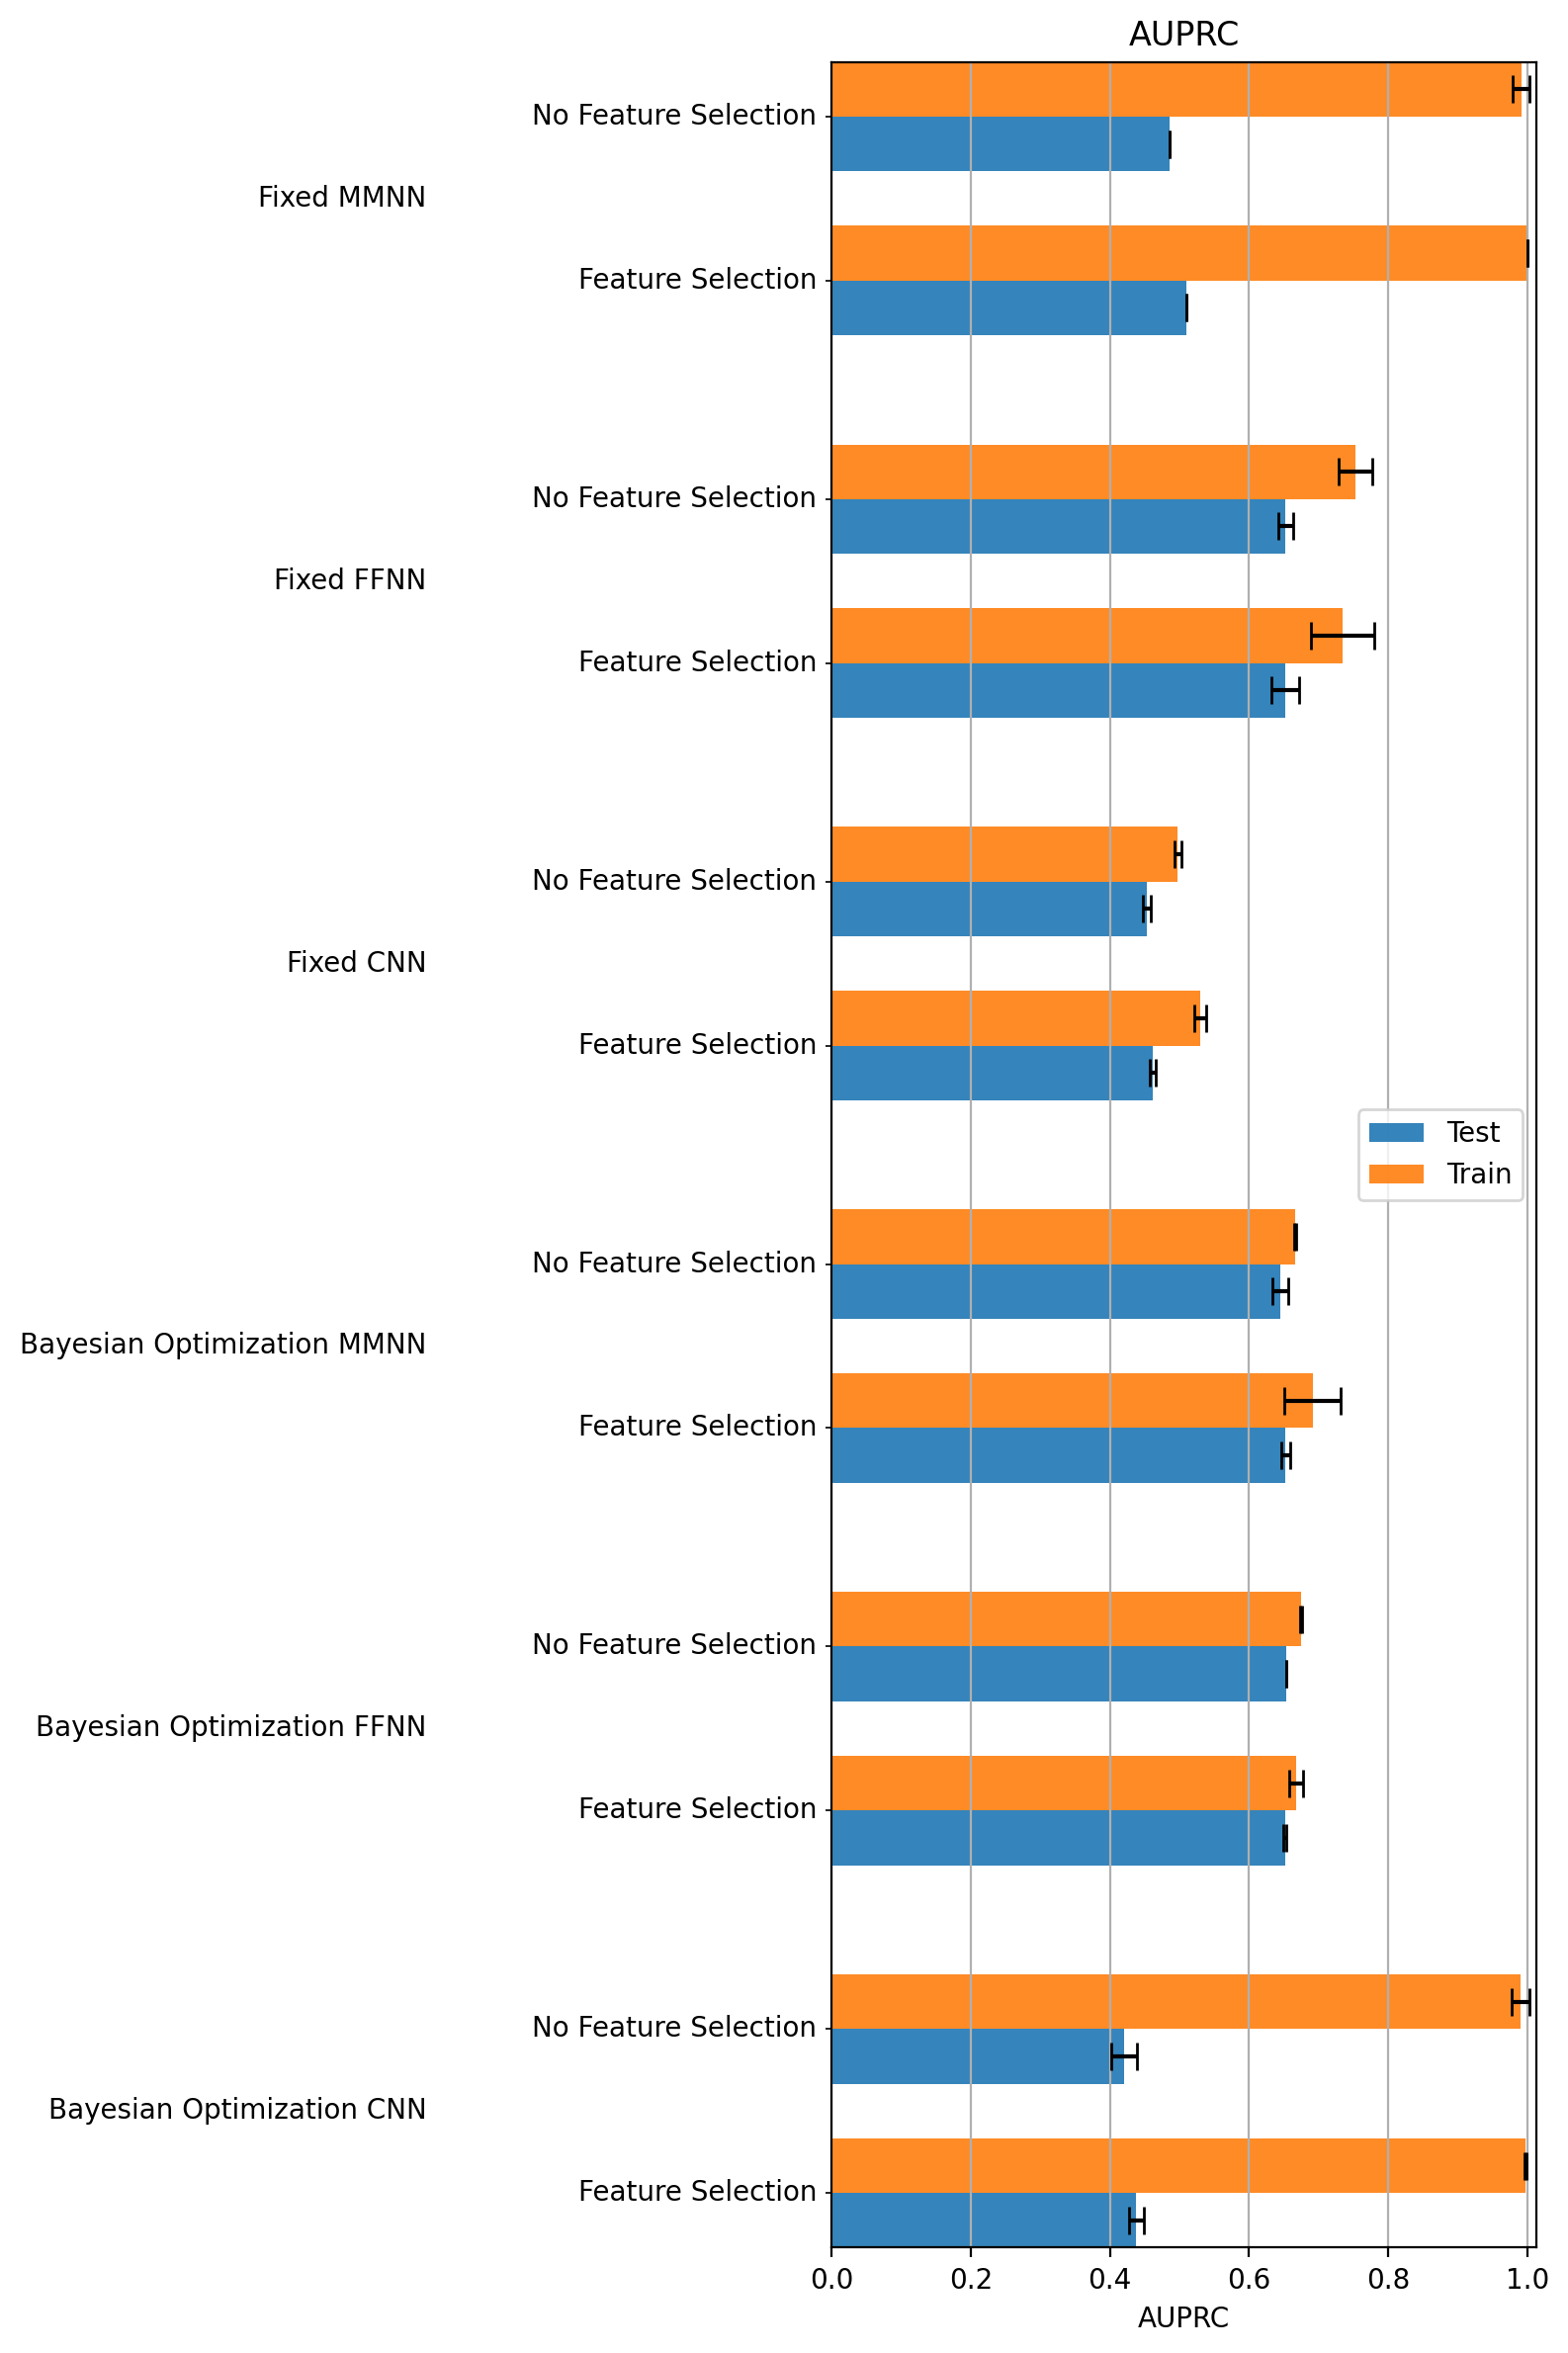

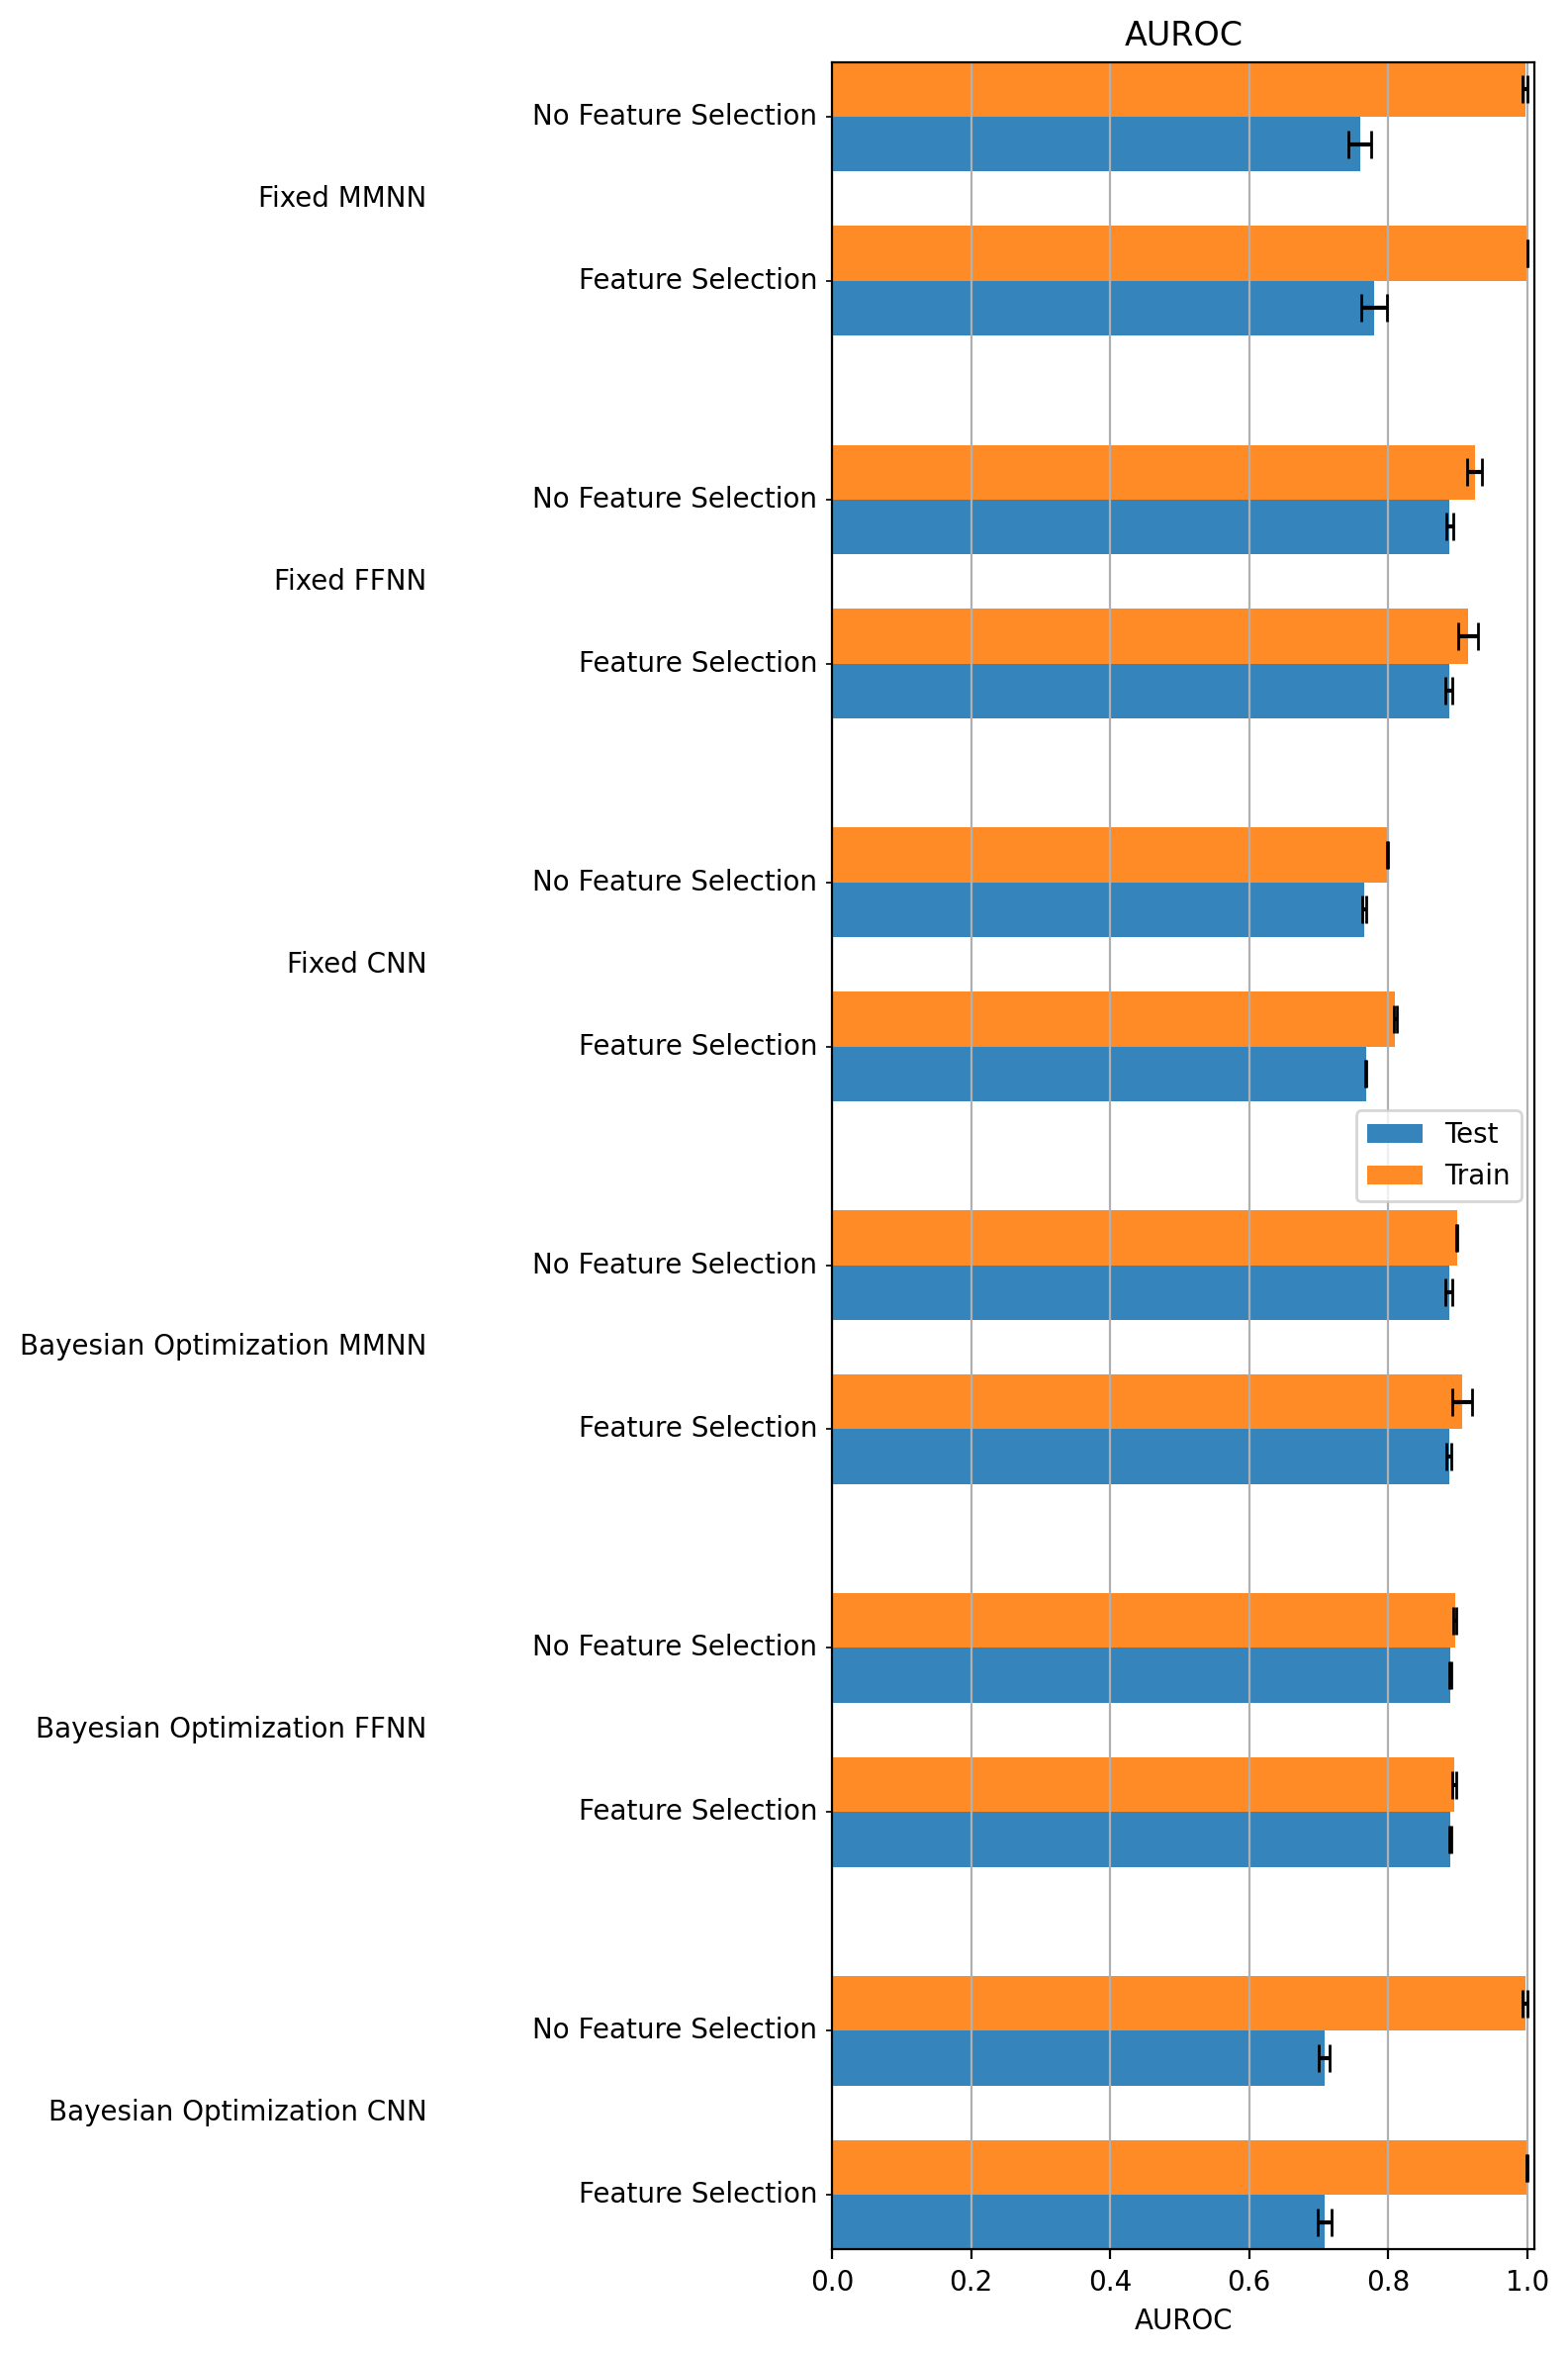

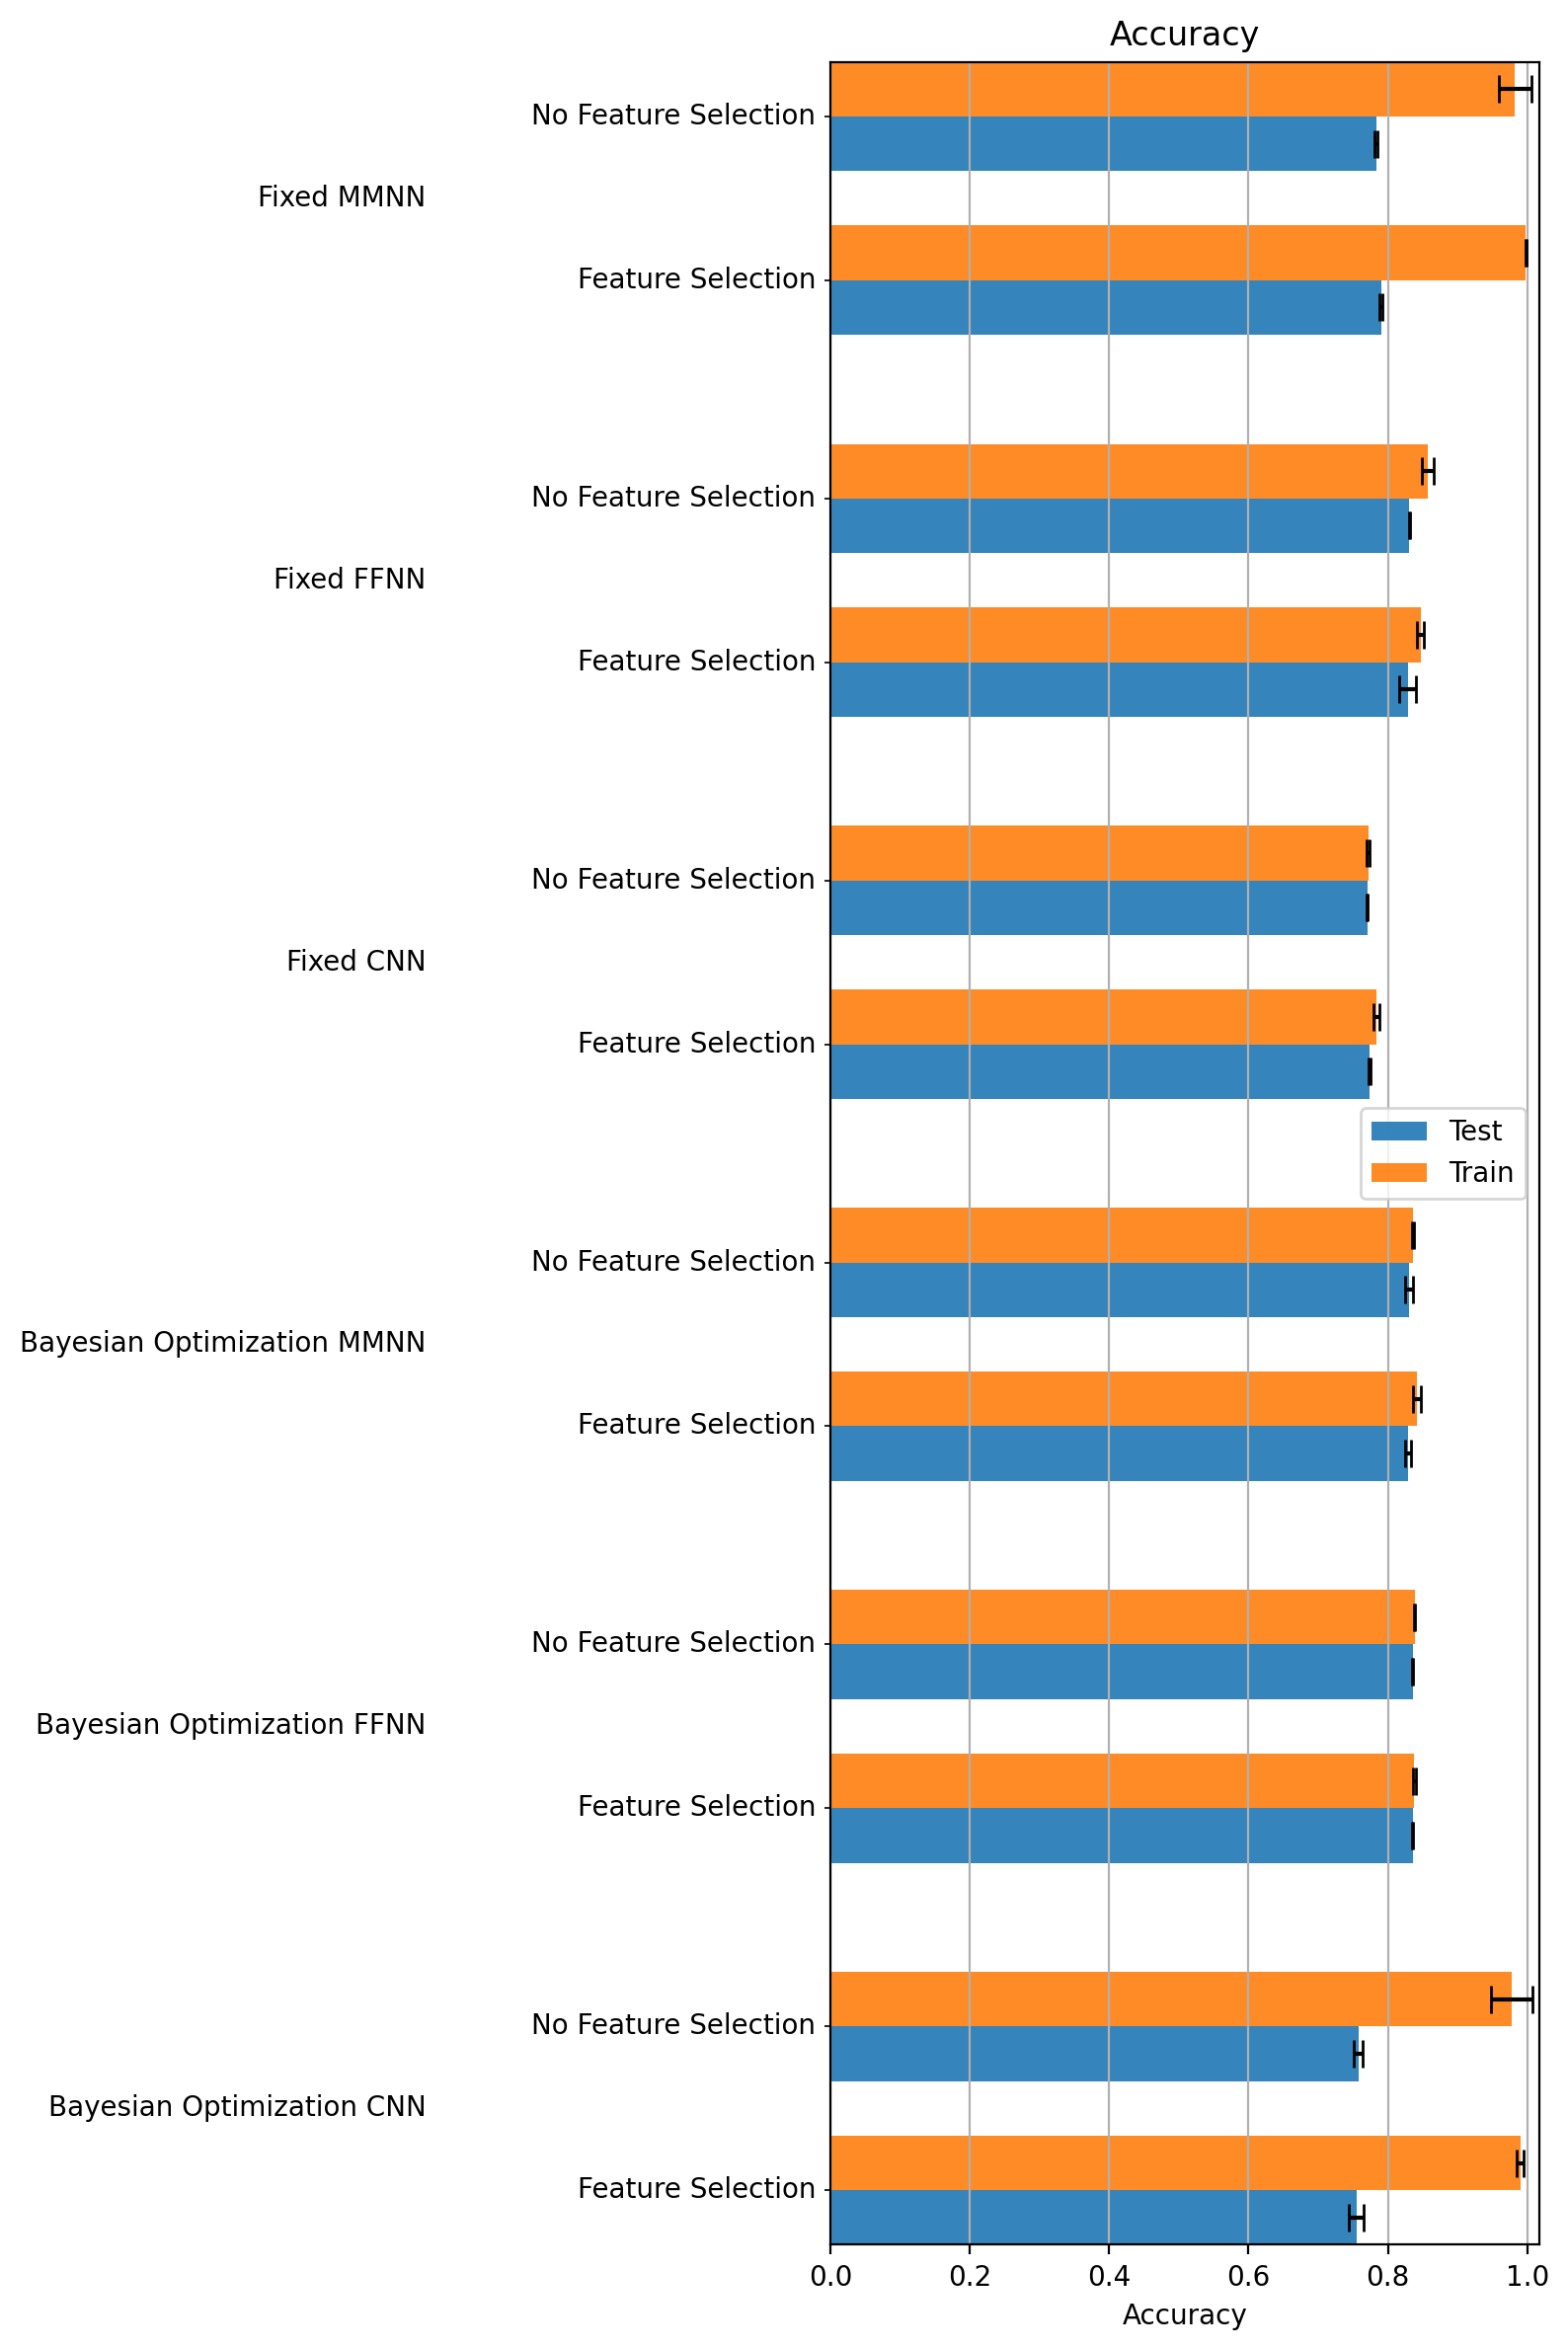

In [138]:
show_result(all_performance, "Promoter")

Rendering barplots:   0%|                                                                                     …

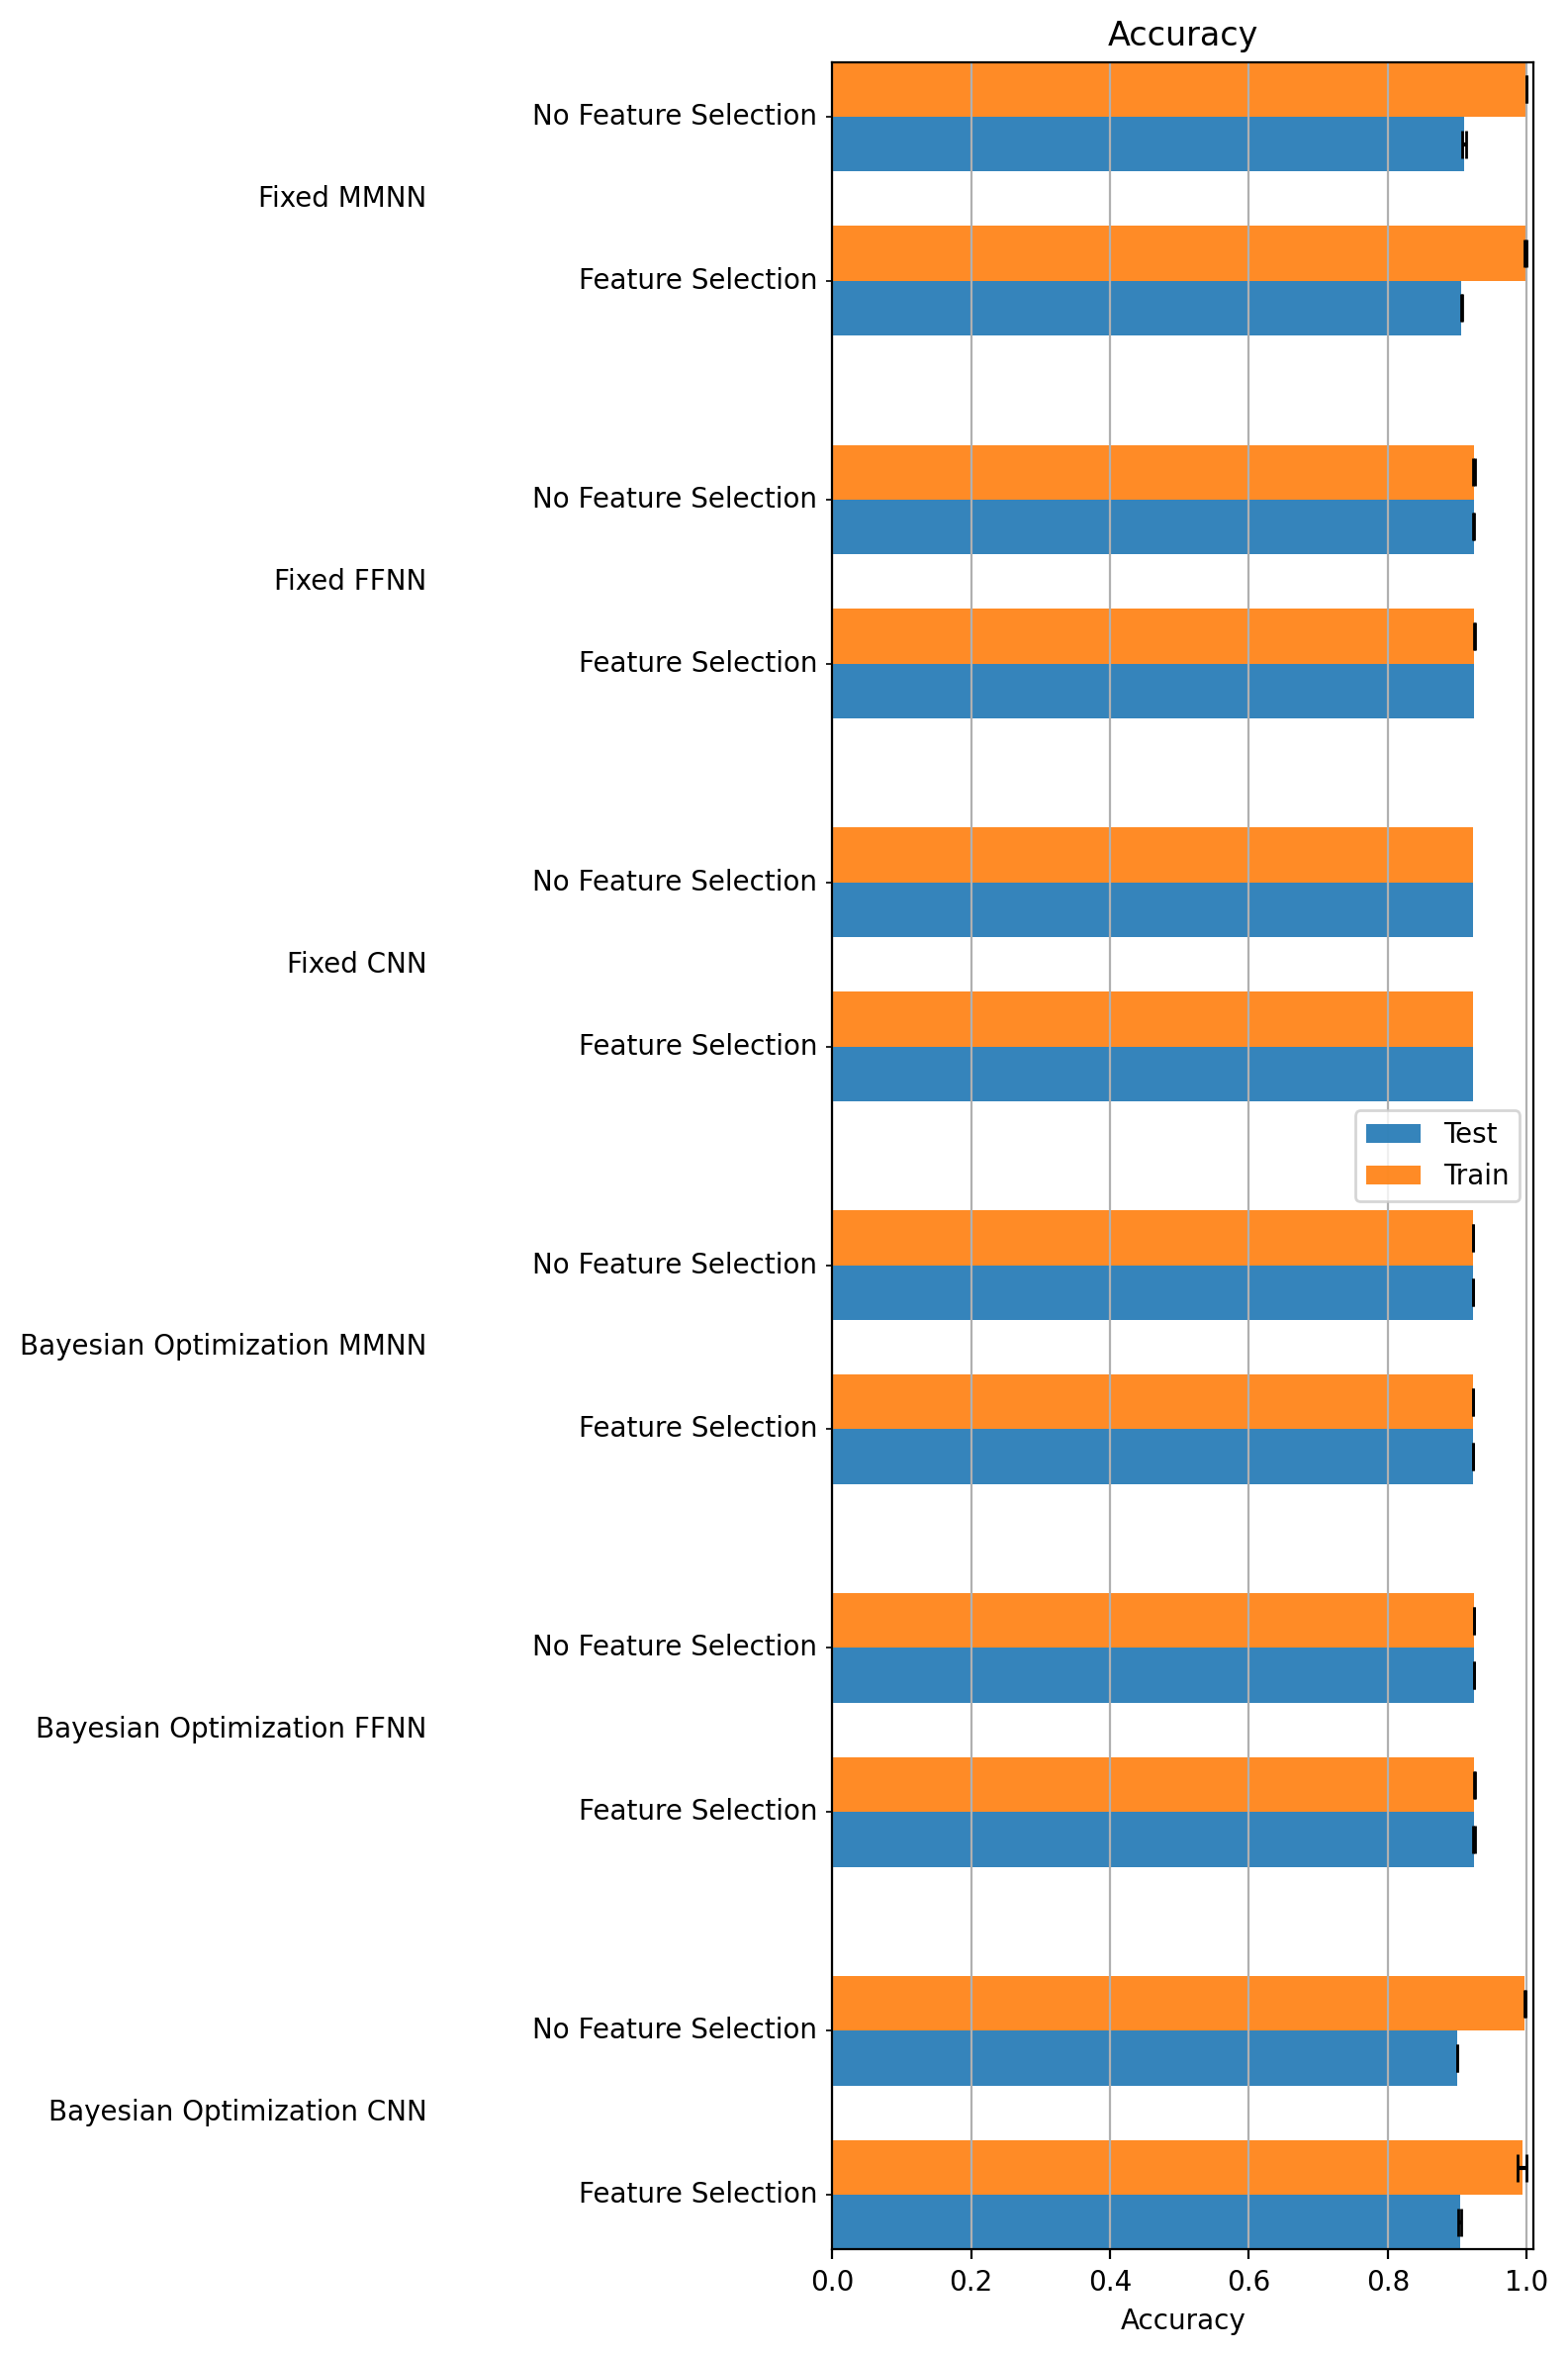

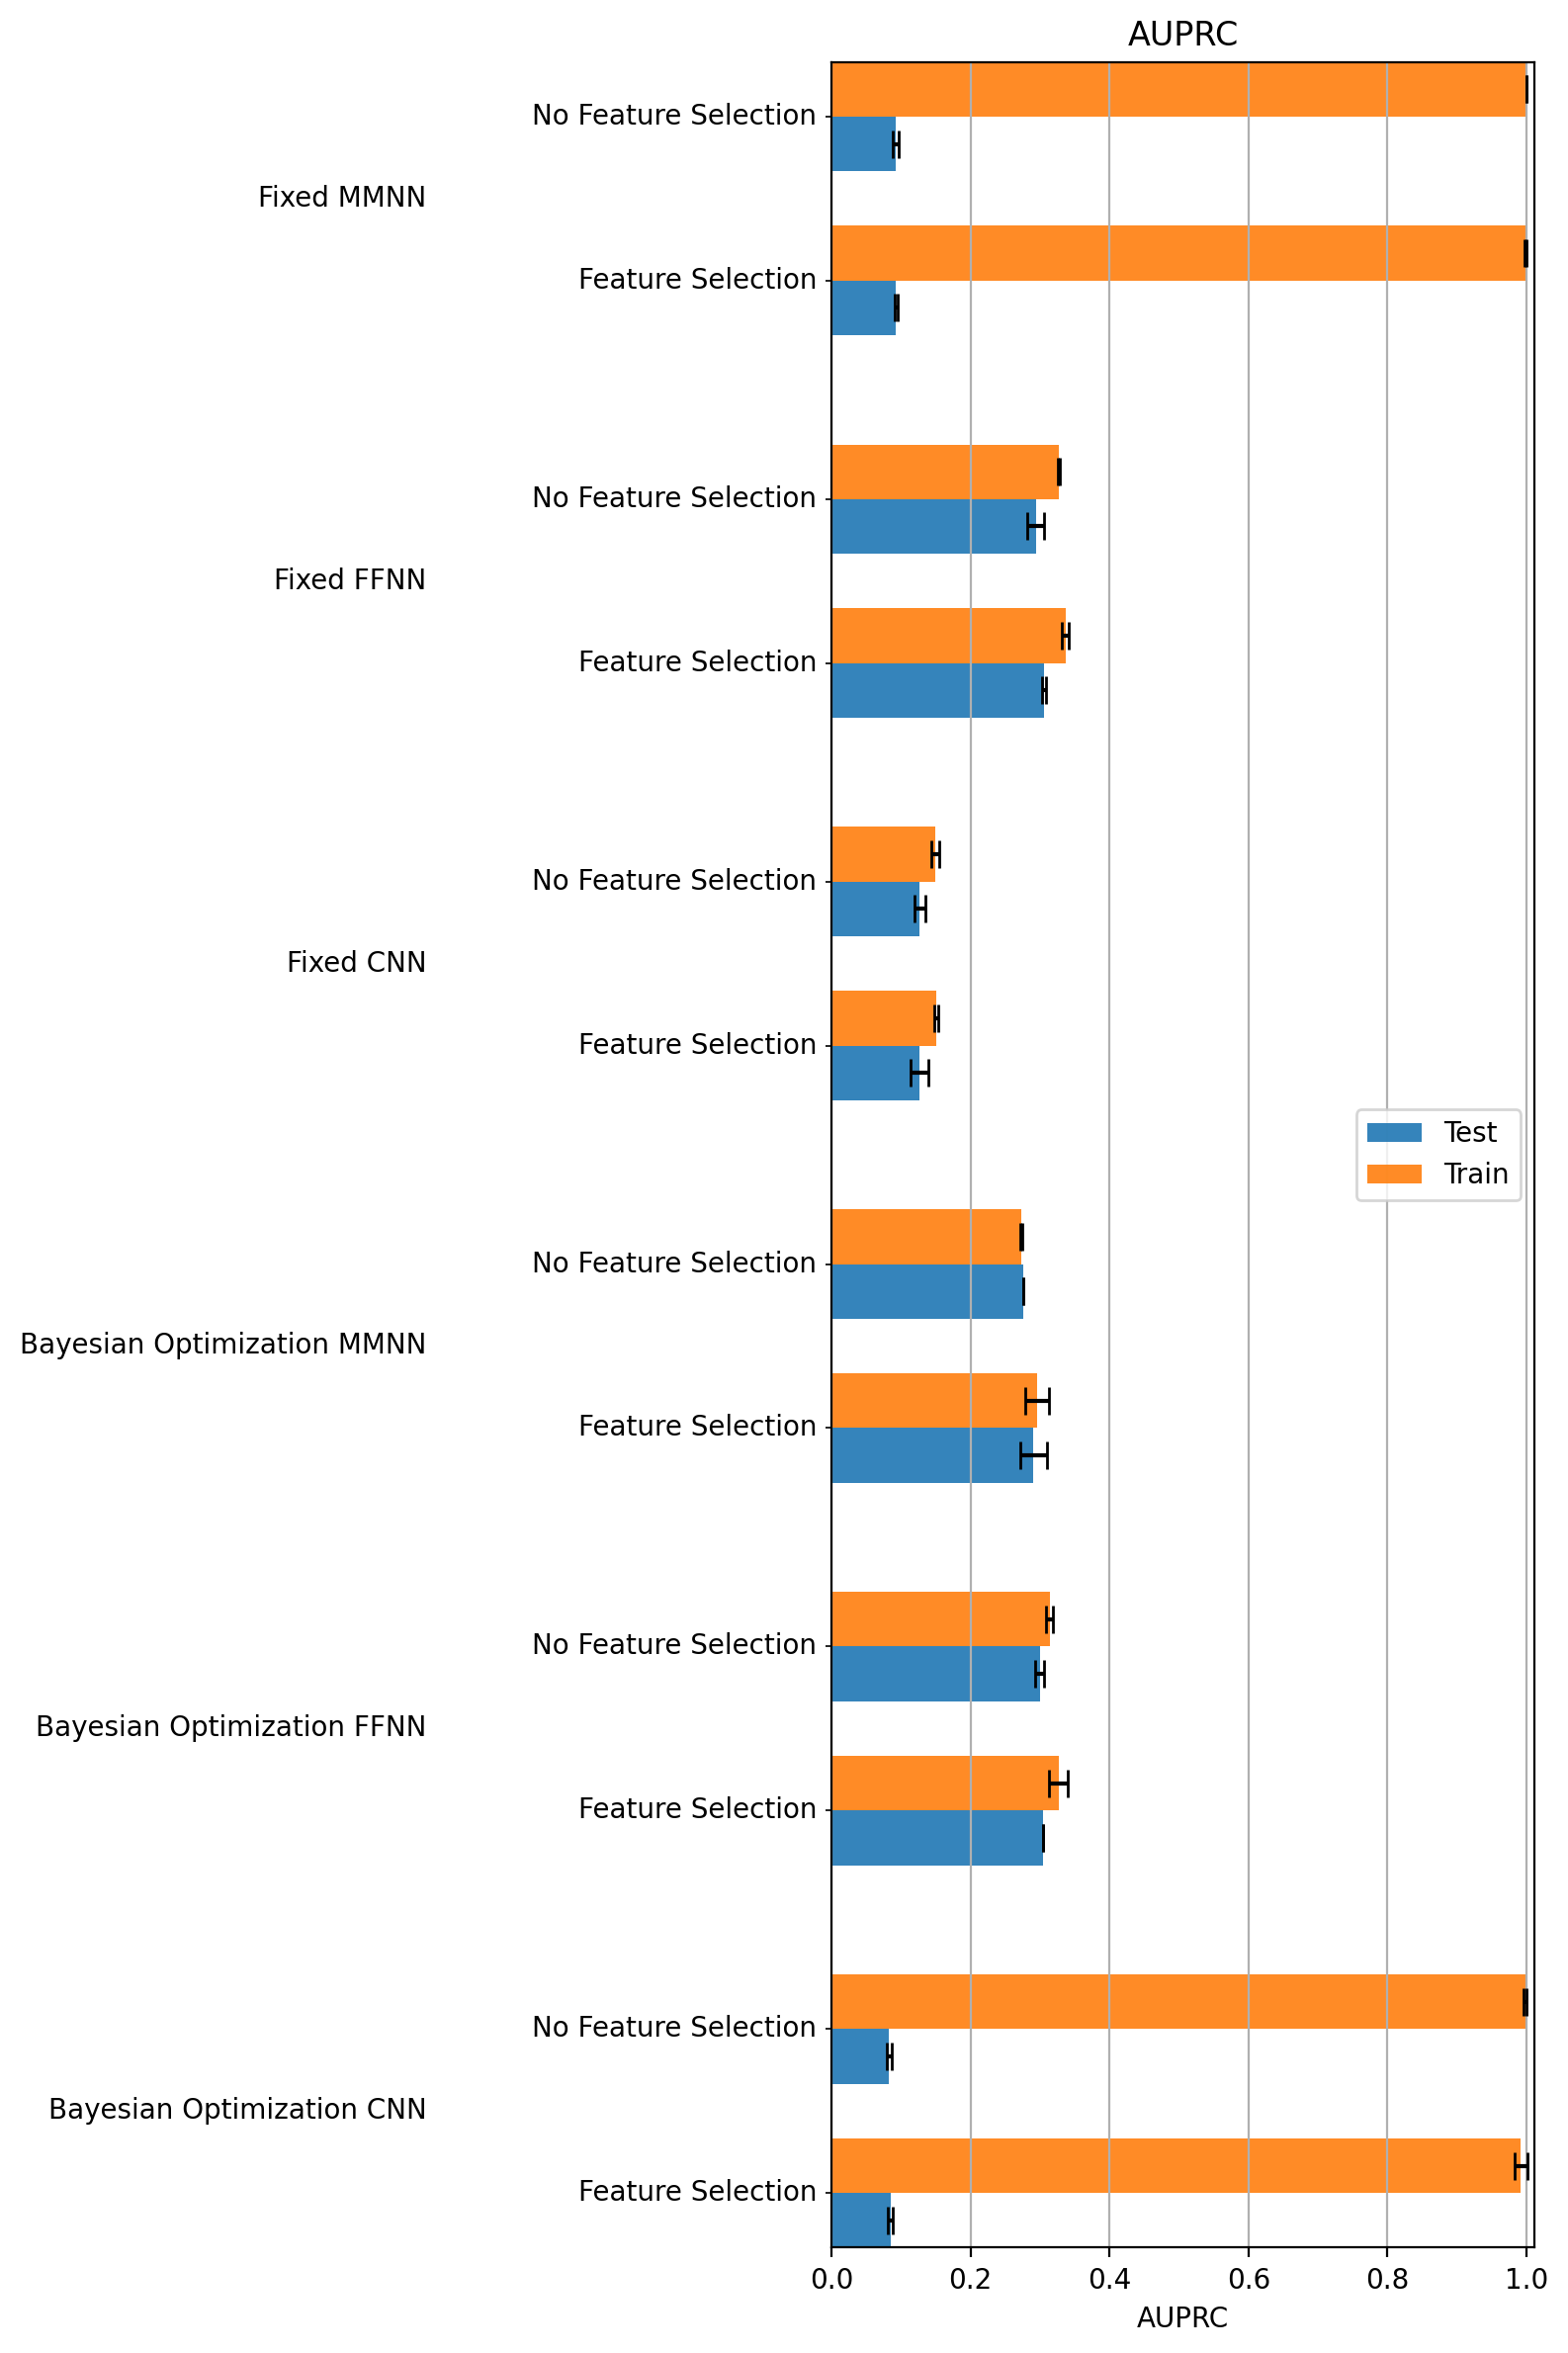

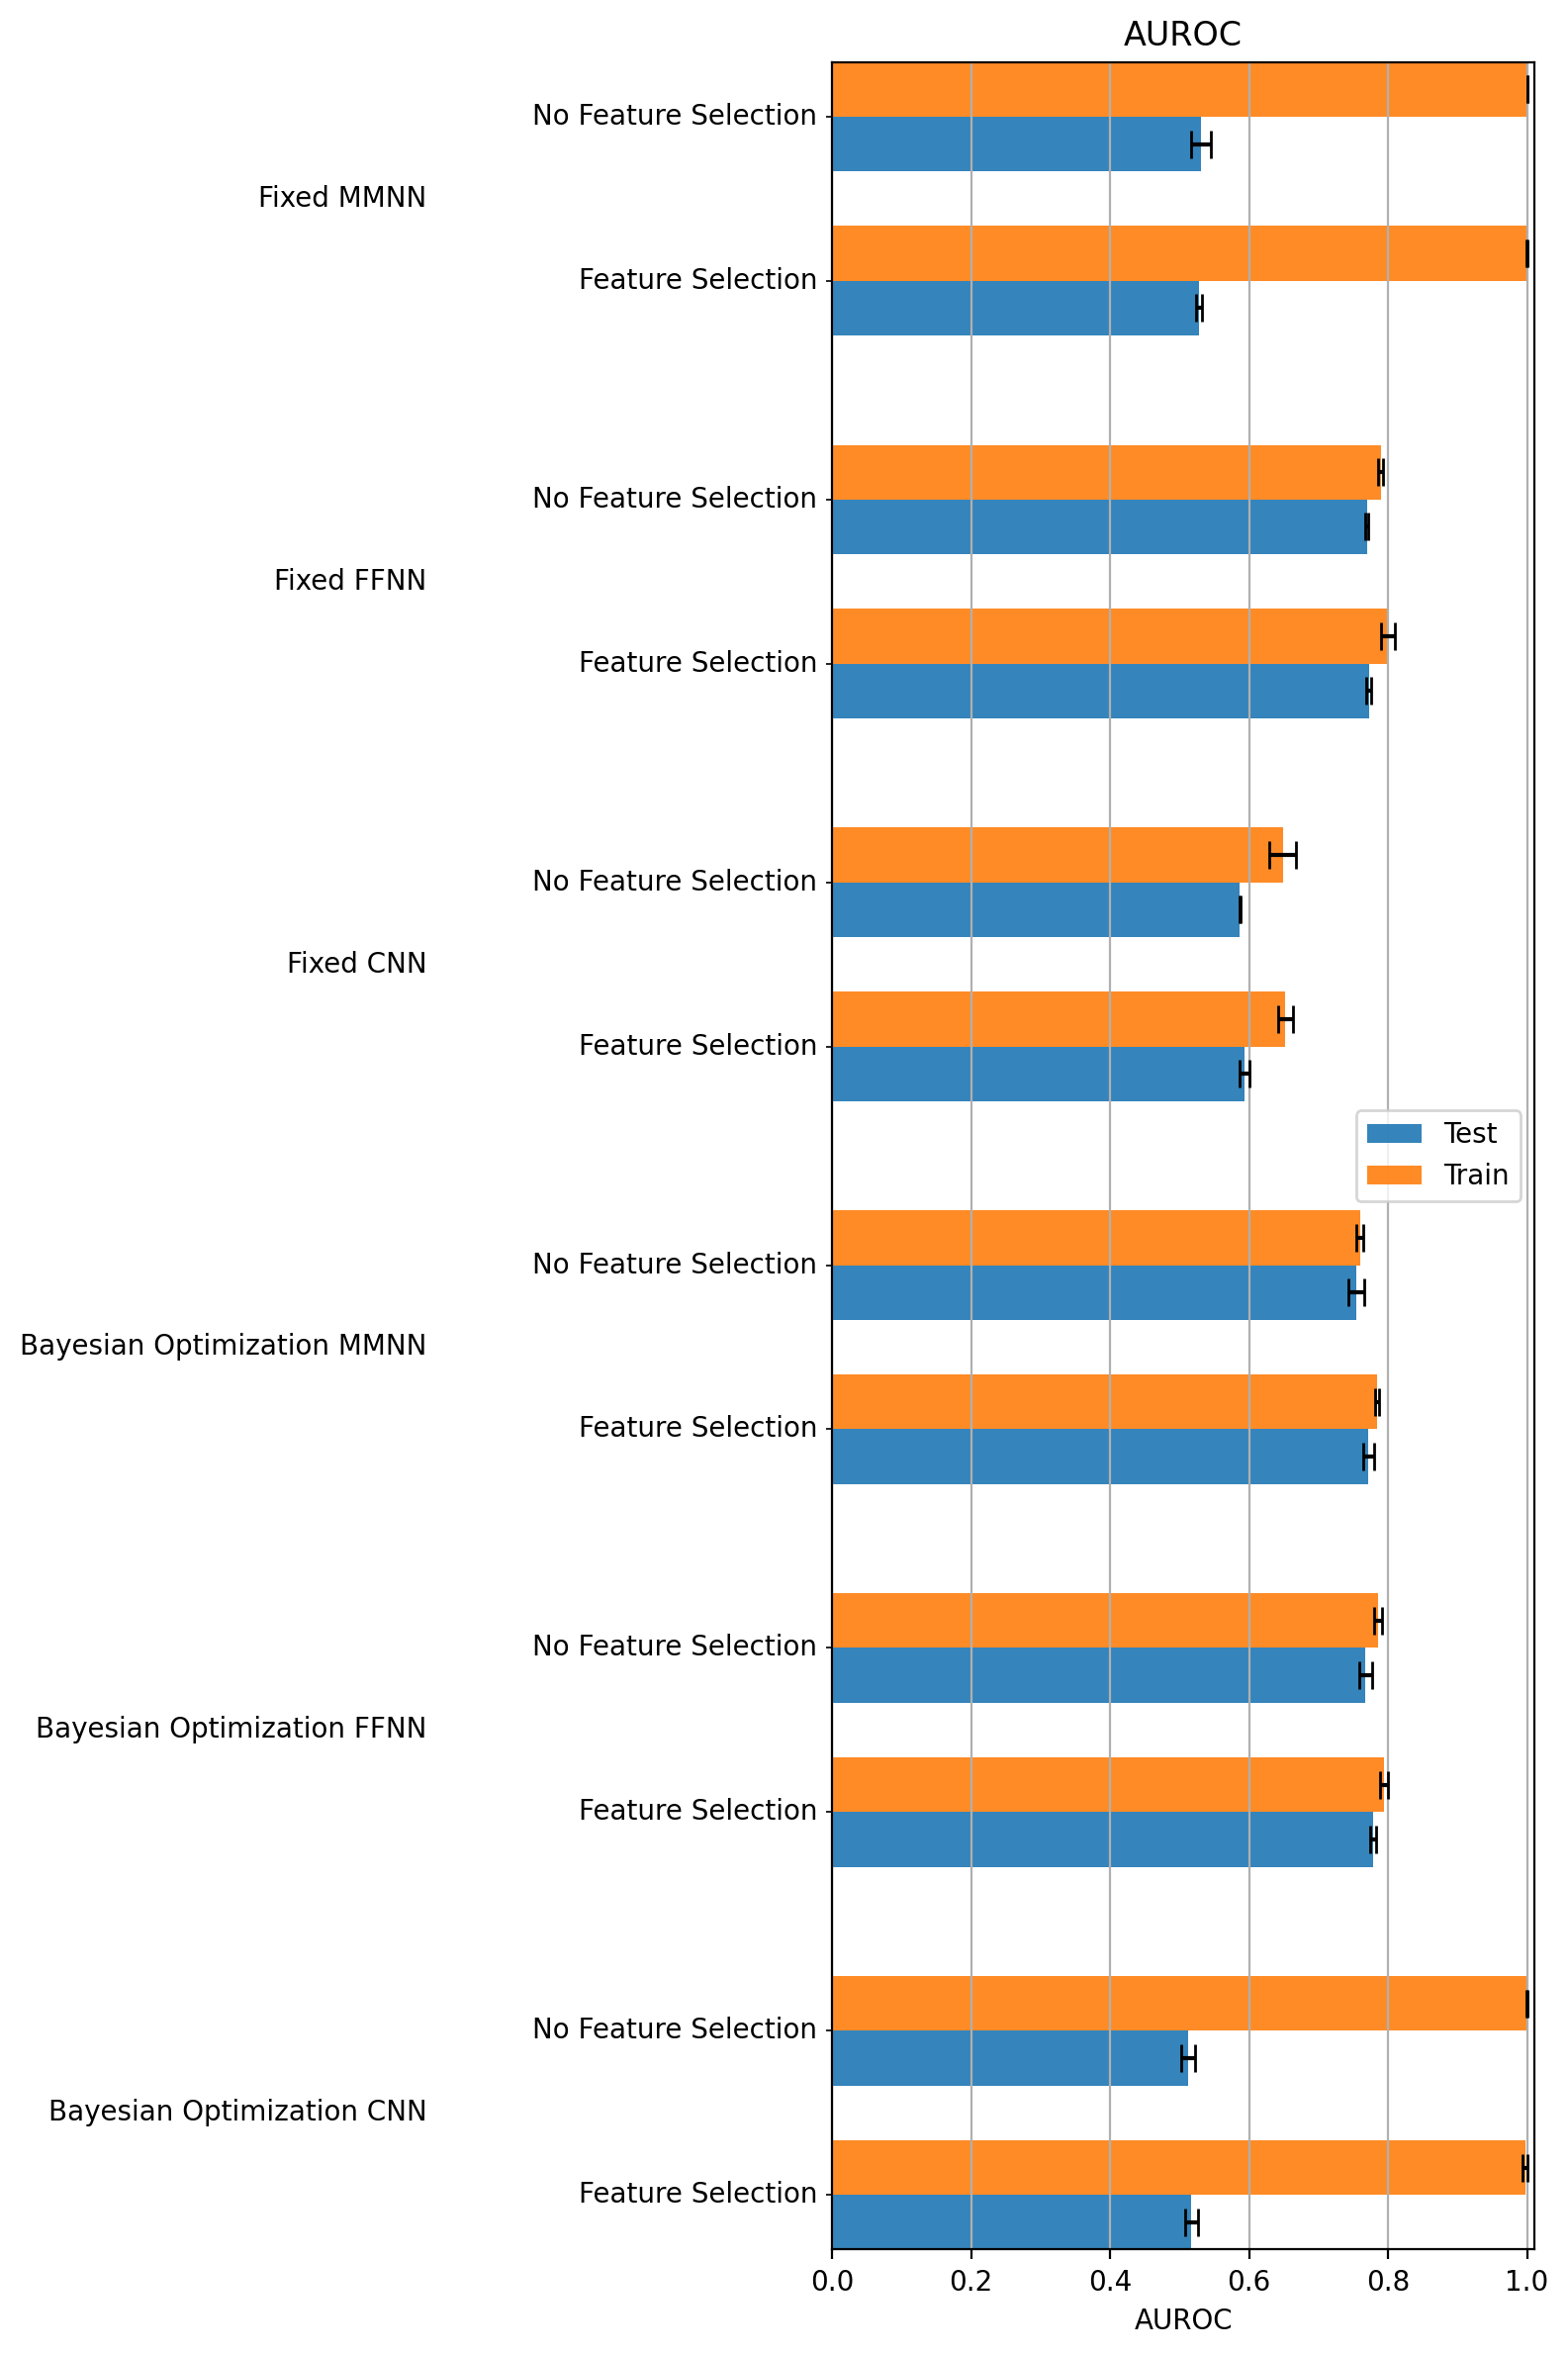

In [139]:
show_result(all_performance, "Enhancer")

#### Wilcoxon Test

In [140]:
for model in all_performance.model_name.unique():
    model_performance = all_performance[
        (all_performance.model_name == model) &
        (all_performance.run_type == "test")]
    performance_with_feature_selection = model_performance[
        all_performance.use_feature_selection == "Feature Selection"
    ]
    performance_without_feature_selection = model_performance[
        all_performance.use_feature_selection == "No Feature Selection"
    ]

    for metric in ("AUPRC", "AUROC", "accuracy"):
        print(
            model,
            metric,
            wilcoxon(performance_with_feature_selection[metric], performance_without_feature_selection[metric])
        )

Bayesian_Optimization_FFNN AUPRC WilcoxonResult(statistic=4.0, pvalue=0.875)
Bayesian_Optimization_FFNN AUROC WilcoxonResult(statistic=3.0, pvalue=0.625)
Bayesian_Optimization_FFNN accuracy WilcoxonResult(statistic=4.0, pvalue=0.875)
Bayesian_Optimization_CNN AUPRC WilcoxonResult(statistic=0.0, pvalue=0.125)
Bayesian_Optimization_CNN AUROC WilcoxonResult(statistic=1.0, pvalue=0.25)
Bayesian_Optimization_CNN accuracy WilcoxonResult(statistic=4.0, pvalue=0.875)
Fixed_FFNN AUPRC WilcoxonResult(statistic=3.0, pvalue=0.625)
Fixed_FFNN AUROC WilcoxonResult(statistic=3.0, pvalue=0.625)
Fixed_FFNN accuracy WilcoxonResult(statistic=5.0, pvalue=1.0)
Fixed_CNN AUPRC WilcoxonResult(statistic=2.0, pvalue=0.375)
Fixed_CNN AUROC WilcoxonResult(statistic=0.0, pvalue=0.125)
Fixed_CNN accuracy WilcoxonResult(statistic=0.0, pvalue=0.17971249487899976)
Fixed_MMNN AUPRC WilcoxonResult(statistic=1.0, pvalue=0.25)
Fixed_MMNN AUROC WilcoxonResult(statistic=4.0, pvalue=0.875)
Fixed_MMNN accuracy WilcoxonResult

In [141]:
for outer_model in all_performance.model_name.unique():
    outer_model_performance = all_performance[
        (all_performance.model_name == outer_model) &
        (all_performance.run_type == "test") & 
        (all_performance.use_feature_selection == "Feature Selection")
    ]
    for model in all_performance.model_name.unique():
        if outer_model >= model:
            continue
        model_performance = all_performance[
            (all_performance.model_name == model) &
            (all_performance.run_type == "test") & 
            (all_performance.use_feature_selection == "Feature Selection")
        ]

        for metric in ("AUPRC", "AUROC", "accuracy"):
            outer, inner = outer_model_performance[metric], model_performance[metric]
            _, p_value = wilcoxon(outer, inner)
            if p_value < 0.01:
                if outer.mean() > inner.mean():
                    best_model, worse_model = outer_model, model
                else:
                    best_model, worse_model = model, outer_model
                print("The model {} outperforms the model {} with p-value {} on metric {}.".format(
                    best_model,
                    worse_model,
                    p_value,
                    metric
                ))
            else:
                print("The model {} is statistially indistinguishiable {} with p-value {} on metric {}.".format(
                    outer_model,
                    model,
                    p_value,
                    metric
                ))

The model Bayesian_Optimization_FFNN is statistially indistinguishiable Fixed_FFNN with p-value 0.875 on metric AUPRC.
The model Bayesian_Optimization_FFNN is statistially indistinguishiable Fixed_FFNN with p-value 0.25 on metric AUROC.
The model Bayesian_Optimization_FFNN is statistially indistinguishiable Fixed_FFNN with p-value 0.875 on metric accuracy.
The model Bayesian_Optimization_FFNN is statistially indistinguishiable Fixed_CNN with p-value 0.125 on metric AUPRC.
The model Bayesian_Optimization_FFNN is statistially indistinguishiable Fixed_CNN with p-value 0.125 on metric AUROC.
The model Bayesian_Optimization_FFNN is statistially indistinguishiable Fixed_CNN with p-value 0.125 on metric accuracy.
The model Bayesian_Optimization_FFNN is statistially indistinguishiable Fixed_MMNN with p-value 0.125 on metric AUPRC.
The model Bayesian_Optimization_FFNN is statistially indistinguishiable Fixed_MMNN with p-value 0.125 on metric AUROC.
The model Bayesian_Optimization_FFNN is statis